# Getting started with Word2Vec in Gensim and making it work!

The idea behind Word2Vec is pretty simple. We are making and assumption that you can tell the meaning of a word by the company it keeps. This is analogous to the saying *show me your friends, and I'll tell who you are*. So if you have two words that have very similar neighbors (i.e. the usage context is about the same), then these words are probably quite similar in meaning or are at least highly related. For example, the words `shocked`,`appalled` and `astonished` are typically used in a similar context. 

In this tutorial, you will learn how to use the Gensim implementation of Word2Vec and actually get it to work! I have heard a lot of complaints about poor performance etc, but its really a combination of two things, (1) your input data and (2) your parameter settings. Note that the training algorithms in this package were ported from the [original Word2Vec implementation by Google](https://arxiv.org/pdf/1301.3781.pdf) and extended with additional functionality.

### Imports and logging

First, we start with our imports and get logging established:

In [2]:
# imports needed and set up logging
import gzip
import gensim 
import logging
import glob, os
import math
import numpy as np

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


### Dataset 
Next, is our dataset. The secret to getting Word2Vec really working for you is to have lots and lots of text data. In this case I am going to use data from the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset. This dataset has full user reviews of cars and hotels. I have specifically concatenated all of the hotel reviews into one big file which is about 97MB compressed and 229MB uncompressed. We will use the compressed file for this tutorial. Each line in this file represents a hotel review. You can download the OpinRank Word2Vec dataset here.

To avoid confusion, while gensim’s word2vec tutorial says that you need to pass it a sequence of sentences as its input, you can always pass it a whole review as a sentence (i.e. a much larger size of text), and it should not make much of a difference. 

Now, let's take a closer look at this data below by printing the first line. You can see that this is a pretty hefty review.

In [3]:
import os,sys
sys.path.insert(0,"/home/msykulski/workspace/genXone/hackyeah2019/jupyter_init_workspace/src/")

import multiprocmap
from multiprocmap import parmap

In [54]:
data_file2=["/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/0**/*",]
            #"/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/1**/*",
            #"/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/2**/*",]
            #"/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/3**/*",]

### Read files into a list
Now that we've had a sneak peak of our dataset, we can read it into a list so that we can pass this on to the Word2Vec model. Notice in the code below, that I am directly reading the 
compressed file. I'm also doing a mild pre-processing of the reviews using `gensim.utils.simple_preprocess (line)`. This does some basic pre-processing such as tokenization, lowercasing, etc and returns back a list of tokens (words). Documentation of this pre-processing method can be found on the official [Gensim documentation site](https://radimrehurek.com/gensim/utils.html). 



In [55]:
%%time 

#filenames=[]

def read_input(input_file_list):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file_list))
    files=[file for input_file in input_file_list for file in glob.glob(input_file)]
    def line_generator(file):
        with open(file, 'rb') as f:
            #filenames.append(file)
            for i, line in enumerate (f): 
            #if (i%10000==0):
                #logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
                yield gensim.utils.simple_preprocess (line)
            yield ["GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF"]
    all_lines=lambda file:(file,[l for l in line_generator(file)])
    #all_f_l=parmap(all_lines)
    return parmap(all_lines,files)
    

# read the tokenized reviews into a list
# each review item becomes a serries of words
# so this becomes a list of lists
#documents2 = list (read_input(data_file2))
all_f_l = read_input(data_file2)

documents2_org = [f_l[1] for f_l in all_f_l]
filenames_org = [f_l[0] for f_l in all_f_l]

logging.info ("Done reading data file")    

2019-09-15 09:09:11,126 : INFO : reading file ['/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/0**/*']...this may take a while
2019-09-15 09:10:17,001 : INFO : Done reading data file


CPU times: user 25.8 s, sys: 30.8 s, total: 56.6 s
Wall time: 1min 5s


In [56]:
print(len(filenames_org))
documents2=[g for l in documents2_org for g in l]

179962


## Training the Word2Vec model

Training the model is fairly straightforward. You just instantiate Word2Vec and pass the reviews that we read in the previous step (the `documents`). So, we are essentially passing on a list of lists. Where each list within the main list contains a set of tokens from a user review. Word2Vec uses all these tokens to internally create a vocabulary. And by vocabulary, I mean a set of unique words.

After building the vocabulary, we just need to call `train(...)` to start training the Word2Vec model. Training on the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset takes about 10 minutes so please be patient while running your code on this dataset.

Behind the scenes we are actually training a simple neural network with a single hidden layer. But, we are actually not going to use the neural network after training. Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn. 

In [10]:
%%time
model = gensim.models.Word2Vec (documents2, size=150, window=10, min_count=1, workers=188)
model.train(documents2,total_examples=len(documents2),epochs=10)

2019-09-15 05:38:50,689 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-09-15 05:38:50,690 : INFO : collecting all words and their counts
2019-09-15 05:38:50,691 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-09-15 05:38:50,707 : INFO : PROGRESS: at sentence #10000, processed 57459 words, keeping 33912 word types
2019-09-15 05:38:50,716 : INFO : PROGRESS: at sentence #20000, processed 94743 words, keeping 43652 word types
2019-09-15 05:38:50,725 : INFO : PROGRESS: at sentence #30000, processed 127729 words, keeping 48819 word types
2019-09-15 05:38:50,734 : INFO : PROGRESS: at sentence #40000, processed 163781 words, keeping 53992 word types
2019-09-15 05:38:50,745 : INFO : PROGRESS: at sentence #50000, processed 205417 words, keeping 65051 word types
2019-09-15 05:38:50,755 : INFO : PROGRESS: at sentence #60000, processed 247372 words, keeping 69060 word types
2019-09-15 05:38:50,765 : INFO : PROGRESS: at sentenc

2019-09-15 05:38:51,386 : INFO : PROGRESS: at sentence #710000, processed 2643479 words, keeping 283254 word types
2019-09-15 05:38:51,397 : INFO : PROGRESS: at sentence #720000, processed 2676713 words, keeping 284898 word types
2019-09-15 05:38:51,406 : INFO : PROGRESS: at sentence #730000, processed 2714195 words, keeping 286573 word types
2019-09-15 05:38:51,415 : INFO : PROGRESS: at sentence #740000, processed 2753904 words, keeping 288423 word types
2019-09-15 05:38:51,425 : INFO : PROGRESS: at sentence #750000, processed 2791244 words, keeping 290015 word types
2019-09-15 05:38:51,435 : INFO : PROGRESS: at sentence #760000, processed 2836841 words, keeping 292244 word types
2019-09-15 05:38:51,445 : INFO : PROGRESS: at sentence #770000, processed 2877146 words, keeping 294080 word types
2019-09-15 05:38:51,455 : INFO : PROGRESS: at sentence #780000, processed 2918421 words, keeping 295842 word types
2019-09-15 05:38:51,464 : INFO : PROGRESS: at sentence #790000, processed 295341

2019-09-15 05:38:52,099 : INFO : PROGRESS: at sentence #1420000, processed 5269450 words, keeping 430835 word types
2019-09-15 05:38:52,108 : INFO : PROGRESS: at sentence #1430000, processed 5305446 words, keeping 432490 word types
2019-09-15 05:38:52,118 : INFO : PROGRESS: at sentence #1440000, processed 5342716 words, keeping 434019 word types
2019-09-15 05:38:52,127 : INFO : PROGRESS: at sentence #1450000, processed 5379440 words, keeping 435408 word types
2019-09-15 05:38:52,136 : INFO : PROGRESS: at sentence #1460000, processed 5418368 words, keeping 437315 word types
2019-09-15 05:38:52,145 : INFO : PROGRESS: at sentence #1470000, processed 5449412 words, keeping 439002 word types
2019-09-15 05:38:52,155 : INFO : PROGRESS: at sentence #1480000, processed 5487466 words, keeping 440801 word types
2019-09-15 05:38:52,165 : INFO : PROGRESS: at sentence #1490000, processed 5527730 words, keeping 442228 word types
2019-09-15 05:38:52,176 : INFO : PROGRESS: at sentence #1500000, process

2019-09-15 05:38:52,846 : INFO : PROGRESS: at sentence #2130000, processed 7895099 words, keeping 586300 word types
2019-09-15 05:38:52,855 : INFO : PROGRESS: at sentence #2140000, processed 7928695 words, keeping 587222 word types
2019-09-15 05:38:52,863 : INFO : PROGRESS: at sentence #2150000, processed 7959901 words, keeping 588326 word types
2019-09-15 05:38:52,873 : INFO : PROGRESS: at sentence #2160000, processed 7994959 words, keeping 589605 word types
2019-09-15 05:38:52,882 : INFO : PROGRESS: at sentence #2170000, processed 8032024 words, keeping 590982 word types
2019-09-15 05:38:52,892 : INFO : PROGRESS: at sentence #2180000, processed 8065029 words, keeping 594713 word types
2019-09-15 05:38:52,905 : INFO : PROGRESS: at sentence #2190000, processed 8093633 words, keeping 600915 word types
2019-09-15 05:38:52,915 : INFO : PROGRESS: at sentence #2200000, processed 8133198 words, keeping 602117 word types
2019-09-15 05:38:52,926 : INFO : PROGRESS: at sentence #2210000, process

2019-09-15 05:38:53,579 : INFO : PROGRESS: at sentence #2840000, processed 10511418 words, keeping 700166 word types
2019-09-15 05:38:53,589 : INFO : PROGRESS: at sentence #2850000, processed 10546901 words, keeping 701998 word types
2019-09-15 05:38:53,599 : INFO : PROGRESS: at sentence #2860000, processed 10584933 words, keeping 703639 word types
2019-09-15 05:38:53,609 : INFO : PROGRESS: at sentence #2870000, processed 10619923 words, keeping 707176 word types
2019-09-15 05:38:53,618 : INFO : PROGRESS: at sentence #2880000, processed 10651364 words, keeping 708254 word types
2019-09-15 05:38:53,626 : INFO : PROGRESS: at sentence #2890000, processed 10675069 words, keeping 713509 word types
2019-09-15 05:38:53,635 : INFO : PROGRESS: at sentence #2900000, processed 10711991 words, keeping 714761 word types
2019-09-15 05:38:53,645 : INFO : PROGRESS: at sentence #2910000, processed 10749612 words, keeping 715892 word types
2019-09-15 05:38:53,654 : INFO : PROGRESS: at sentence #2920000,

2019-09-15 05:38:54,279 : INFO : PROGRESS: at sentence #3550000, processed 13135220 words, keeping 830098 word types
2019-09-15 05:38:54,289 : INFO : PROGRESS: at sentence #3560000, processed 13176889 words, keeping 831638 word types
2019-09-15 05:38:54,298 : INFO : PROGRESS: at sentence #3570000, processed 13210682 words, keeping 833048 word types
2019-09-15 05:38:54,308 : INFO : PROGRESS: at sentence #3580000, processed 13246581 words, keeping 834661 word types
2019-09-15 05:38:54,318 : INFO : PROGRESS: at sentence #3590000, processed 13287198 words, keeping 835700 word types
2019-09-15 05:38:54,327 : INFO : PROGRESS: at sentence #3600000, processed 13324403 words, keeping 836950 word types
2019-09-15 05:38:54,337 : INFO : PROGRESS: at sentence #3610000, processed 13362787 words, keeping 838044 word types
2019-09-15 05:38:54,346 : INFO : PROGRESS: at sentence #3620000, processed 13392986 words, keeping 838998 word types
2019-09-15 05:38:54,354 : INFO : PROGRESS: at sentence #3630000,

2019-09-15 05:38:54,973 : INFO : PROGRESS: at sentence #4260000, processed 15753217 words, keeping 948712 word types
2019-09-15 05:38:54,984 : INFO : PROGRESS: at sentence #4270000, processed 15795894 words, keeping 950209 word types
2019-09-15 05:38:54,993 : INFO : PROGRESS: at sentence #4280000, processed 15827095 words, keeping 951724 word types
2019-09-15 05:38:55,002 : INFO : PROGRESS: at sentence #4290000, processed 15863651 words, keeping 952706 word types
2019-09-15 05:38:55,012 : INFO : PROGRESS: at sentence #4300000, processed 15900215 words, keeping 953935 word types
2019-09-15 05:38:55,022 : INFO : PROGRESS: at sentence #4310000, processed 15939085 words, keeping 954830 word types
2019-09-15 05:38:55,032 : INFO : PROGRESS: at sentence #4320000, processed 15975015 words, keeping 956019 word types
2019-09-15 05:38:55,043 : INFO : PROGRESS: at sentence #4330000, processed 16014143 words, keeping 957159 word types
2019-09-15 05:38:55,054 : INFO : PROGRESS: at sentence #4340000,

2019-09-15 05:38:55,671 : INFO : PROGRESS: at sentence #4960000, processed 18392228 words, keeping 1040987 word types
2019-09-15 05:38:55,681 : INFO : PROGRESS: at sentence #4970000, processed 18428805 words, keeping 1043709 word types
2019-09-15 05:38:55,691 : INFO : PROGRESS: at sentence #4980000, processed 18457861 words, keeping 1047508 word types
2019-09-15 05:38:55,701 : INFO : PROGRESS: at sentence #4990000, processed 18496085 words, keeping 1048563 word types
2019-09-15 05:38:55,711 : INFO : PROGRESS: at sentence #5000000, processed 18533777 words, keeping 1049516 word types
2019-09-15 05:38:55,720 : INFO : PROGRESS: at sentence #5010000, processed 18569720 words, keeping 1050184 word types
2019-09-15 05:38:55,729 : INFO : PROGRESS: at sentence #5020000, processed 18604452 words, keeping 1051267 word types
2019-09-15 05:38:55,740 : INFO : PROGRESS: at sentence #5030000, processed 18645080 words, keeping 1053107 word types
2019-09-15 05:38:55,750 : INFO : PROGRESS: at sentence #

2019-09-15 05:38:56,375 : INFO : PROGRESS: at sentence #5660000, processed 21018666 words, keeping 1174253 word types
2019-09-15 05:38:56,386 : INFO : PROGRESS: at sentence #5670000, processed 21061041 words, keeping 1175592 word types
2019-09-15 05:38:56,395 : INFO : PROGRESS: at sentence #5680000, processed 21094844 words, keeping 1176712 word types
2019-09-15 05:38:56,403 : INFO : PROGRESS: at sentence #5690000, processed 21127490 words, keeping 1177292 word types
2019-09-15 05:38:56,412 : INFO : PROGRESS: at sentence #5700000, processed 21161413 words, keeping 1177956 word types
2019-09-15 05:38:56,423 : INFO : PROGRESS: at sentence #5710000, processed 21204415 words, keeping 1179599 word types
2019-09-15 05:38:56,434 : INFO : PROGRESS: at sentence #5720000, processed 21252703 words, keeping 1180677 word types
2019-09-15 05:38:56,443 : INFO : PROGRESS: at sentence #5730000, processed 21285251 words, keeping 1181752 word types
2019-09-15 05:38:56,452 : INFO : PROGRESS: at sentence #

2019-09-15 05:38:57,095 : INFO : PROGRESS: at sentence #6360000, processed 23578381 words, keeping 1276840 word types
2019-09-15 05:38:57,106 : INFO : PROGRESS: at sentence #6370000, processed 23622951 words, keeping 1277908 word types
2019-09-15 05:38:57,116 : INFO : PROGRESS: at sentence #6380000, processed 23658218 words, keeping 1278768 word types
2019-09-15 05:38:57,125 : INFO : PROGRESS: at sentence #6390000, processed 23694656 words, keeping 1279911 word types
2019-09-15 05:38:57,135 : INFO : PROGRESS: at sentence #6400000, processed 23731223 words, keeping 1280795 word types
2019-09-15 05:38:57,143 : INFO : PROGRESS: at sentence #6410000, processed 23761072 words, keeping 1281632 word types
2019-09-15 05:38:57,153 : INFO : PROGRESS: at sentence #6420000, processed 23797053 words, keeping 1282574 word types
2019-09-15 05:38:57,162 : INFO : PROGRESS: at sentence #6430000, processed 23832320 words, keeping 1283376 word types
2019-09-15 05:38:57,173 : INFO : PROGRESS: at sentence #

2019-09-15 05:38:57,794 : INFO : PROGRESS: at sentence #7060000, processed 26181935 words, keeping 1369973 word types
2019-09-15 05:38:57,805 : INFO : PROGRESS: at sentence #7070000, processed 26221271 words, keeping 1373101 word types
2019-09-15 05:38:57,815 : INFO : PROGRESS: at sentence #7080000, processed 26260483 words, keeping 1374014 word types
2019-09-15 05:38:57,825 : INFO : PROGRESS: at sentence #7090000, processed 26301172 words, keeping 1375058 word types
2019-09-15 05:38:57,837 : INFO : PROGRESS: at sentence #7100000, processed 26346046 words, keeping 1376520 word types
2019-09-15 05:38:57,846 : INFO : PROGRESS: at sentence #7110000, processed 26373983 words, keeping 1379861 word types
2019-09-15 05:38:57,858 : INFO : PROGRESS: at sentence #7120000, processed 26404819 words, keeping 1382997 word types
2019-09-15 05:38:57,868 : INFO : PROGRESS: at sentence #7130000, processed 26444801 words, keeping 1384125 word types
2019-09-15 05:38:57,877 : INFO : PROGRESS: at sentence #

2019-09-15 05:38:58,544 : INFO : PROGRESS: at sentence #7760000, processed 28845490 words, keeping 1450603 word types
2019-09-15 05:38:58,556 : INFO : PROGRESS: at sentence #7770000, processed 28898169 words, keeping 1452248 word types
2019-09-15 05:38:58,566 : INFO : PROGRESS: at sentence #7780000, processed 28935571 words, keeping 1453345 word types
2019-09-15 05:38:58,576 : INFO : PROGRESS: at sentence #7790000, processed 28971850 words, keeping 1454251 word types
2019-09-15 05:38:58,585 : INFO : PROGRESS: at sentence #7800000, processed 29009879 words, keeping 1455050 word types
2019-09-15 05:38:58,595 : INFO : PROGRESS: at sentence #7810000, processed 29044880 words, keeping 1455770 word types
2019-09-15 05:38:58,606 : INFO : PROGRESS: at sentence #7820000, processed 29083279 words, keeping 1456653 word types
2019-09-15 05:38:58,616 : INFO : PROGRESS: at sentence #7830000, processed 29122295 words, keeping 1457452 word types
2019-09-15 05:38:58,625 : INFO : PROGRESS: at sentence #

2019-09-15 05:38:59,241 : INFO : PROGRESS: at sentence #8460000, processed 31415123 words, keeping 1571975 word types
2019-09-15 05:38:59,251 : INFO : PROGRESS: at sentence #8470000, processed 31451165 words, keeping 1572823 word types
2019-09-15 05:38:59,259 : INFO : PROGRESS: at sentence #8480000, processed 31480722 words, keeping 1573960 word types
2019-09-15 05:38:59,269 : INFO : PROGRESS: at sentence #8490000, processed 31520689 words, keeping 1574989 word types
2019-09-15 05:38:59,278 : INFO : PROGRESS: at sentence #8500000, processed 31555947 words, keeping 1575682 word types
2019-09-15 05:38:59,287 : INFO : PROGRESS: at sentence #8510000, processed 31587260 words, keeping 1576633 word types
2019-09-15 05:38:59,297 : INFO : PROGRESS: at sentence #8520000, processed 31627944 words, keeping 1577566 word types
2019-09-15 05:38:59,306 : INFO : PROGRESS: at sentence #8530000, processed 31664107 words, keeping 1579011 word types
2019-09-15 05:38:59,316 : INFO : PROGRESS: at sentence #

2019-09-15 05:38:59,916 : INFO : PROGRESS: at sentence #9160000, processed 33947727 words, keeping 1655924 word types
2019-09-15 05:38:59,925 : INFO : PROGRESS: at sentence #9170000, processed 33984822 words, keeping 1656906 word types
2019-09-15 05:38:59,936 : INFO : PROGRESS: at sentence #9180000, processed 34026004 words, keeping 1658412 word types
2019-09-15 05:38:59,946 : INFO : PROGRESS: at sentence #9190000, processed 34066556 words, keeping 1659524 word types
2019-09-15 05:38:59,956 : INFO : PROGRESS: at sentence #9200000, processed 34102735 words, keeping 1661027 word types
2019-09-15 05:38:59,966 : INFO : PROGRESS: at sentence #9210000, processed 34142191 words, keeping 1662158 word types
2019-09-15 05:38:59,977 : INFO : PROGRESS: at sentence #9220000, processed 34188575 words, keeping 1663274 word types
2019-09-15 05:38:59,989 : INFO : PROGRESS: at sentence #9230000, processed 34229073 words, keeping 1668110 word types
2019-09-15 05:39:00,000 : INFO : PROGRESS: at sentence #

2019-09-15 05:39:00,616 : INFO : PROGRESS: at sentence #9860000, processed 36550705 words, keeping 1742259 word types
2019-09-15 05:39:00,626 : INFO : PROGRESS: at sentence #9870000, processed 36592383 words, keeping 1743382 word types
2019-09-15 05:39:00,637 : INFO : PROGRESS: at sentence #9880000, processed 36632670 words, keeping 1744248 word types
2019-09-15 05:39:00,646 : INFO : PROGRESS: at sentence #9890000, processed 36669424 words, keeping 1745087 word types
2019-09-15 05:39:00,657 : INFO : PROGRESS: at sentence #9900000, processed 36705501 words, keeping 1747700 word types
2019-09-15 05:39:00,671 : INFO : PROGRESS: at sentence #9910000, processed 36763094 words, keeping 1751906 word types
2019-09-15 05:39:00,682 : INFO : PROGRESS: at sentence #9920000, processed 36802941 words, keeping 1752969 word types
2019-09-15 05:39:00,690 : INFO : PROGRESS: at sentence #9930000, processed 36831606 words, keeping 1754006 word types
2019-09-15 05:39:00,699 : INFO : PROGRESS: at sentence #

2019-09-15 05:39:01,333 : INFO : PROGRESS: at sentence #10550000, processed 39108609 words, keeping 1848348 word types
2019-09-15 05:39:01,346 : INFO : PROGRESS: at sentence #10560000, processed 39154248 words, keeping 1852302 word types
2019-09-15 05:39:01,359 : INFO : PROGRESS: at sentence #10570000, processed 39199304 words, keeping 1857928 word types
2019-09-15 05:39:01,369 : INFO : PROGRESS: at sentence #10580000, processed 39240562 words, keeping 1859222 word types
2019-09-15 05:39:01,378 : INFO : PROGRESS: at sentence #10590000, processed 39273768 words, keeping 1859890 word types
2019-09-15 05:39:01,388 : INFO : PROGRESS: at sentence #10600000, processed 39304413 words, keeping 1862087 word types
2019-09-15 05:39:01,398 : INFO : PROGRESS: at sentence #10610000, processed 39342391 words, keeping 1863584 word types
2019-09-15 05:39:01,407 : INFO : PROGRESS: at sentence #10620000, processed 39372650 words, keeping 1864509 word types
2019-09-15 05:39:01,418 : INFO : PROGRESS: at se

2019-09-15 05:39:02,028 : INFO : PROGRESS: at sentence #11240000, processed 41611275 words, keeping 1935955 word types
2019-09-15 05:39:02,038 : INFO : PROGRESS: at sentence #11250000, processed 41651266 words, keeping 1936556 word types
2019-09-15 05:39:02,049 : INFO : PROGRESS: at sentence #11260000, processed 41695953 words, keeping 1937350 word types
2019-09-15 05:39:02,057 : INFO : PROGRESS: at sentence #11270000, processed 41726776 words, keeping 1938016 word types
2019-09-15 05:39:02,069 : INFO : PROGRESS: at sentence #11280000, processed 41759485 words, keeping 1938769 word types
2019-09-15 05:39:02,082 : INFO : PROGRESS: at sentence #11290000, processed 41809800 words, keeping 1940716 word types
2019-09-15 05:39:02,091 : INFO : PROGRESS: at sentence #11300000, processed 41841125 words, keeping 1941644 word types
2019-09-15 05:39:02,101 : INFO : PROGRESS: at sentence #11310000, processed 41877584 words, keeping 1942539 word types
2019-09-15 05:39:02,111 : INFO : PROGRESS: at se

2019-09-15 05:39:02,746 : INFO : PROGRESS: at sentence #11930000, processed 44203690 words, keeping 2043896 word types
2019-09-15 05:39:02,756 : INFO : PROGRESS: at sentence #11940000, processed 44241960 words, keeping 2044631 word types
2019-09-15 05:39:02,767 : INFO : PROGRESS: at sentence #11950000, processed 44279683 words, keeping 2045399 word types
2019-09-15 05:39:02,777 : INFO : PROGRESS: at sentence #11960000, processed 44315330 words, keeping 2046127 word types
2019-09-15 05:39:02,789 : INFO : PROGRESS: at sentence #11970000, processed 44360595 words, keeping 2047018 word types
2019-09-15 05:39:02,799 : INFO : PROGRESS: at sentence #11980000, processed 44399080 words, keeping 2047980 word types
2019-09-15 05:39:02,809 : INFO : PROGRESS: at sentence #11990000, processed 44439261 words, keeping 2048721 word types
2019-09-15 05:39:02,819 : INFO : PROGRESS: at sentence #12000000, processed 44472533 words, keeping 2049370 word types
2019-09-15 05:39:02,827 : INFO : PROGRESS: at se

2019-09-15 05:39:03,470 : INFO : PROGRESS: at sentence #12620000, processed 46702846 words, keeping 2115429 word types
2019-09-15 05:39:03,484 : INFO : PROGRESS: at sentence #12630000, processed 46754267 words, keeping 2116913 word types
2019-09-15 05:39:03,496 : INFO : PROGRESS: at sentence #12640000, processed 46794335 words, keeping 2117723 word types
2019-09-15 05:39:03,507 : INFO : PROGRESS: at sentence #12650000, processed 46831678 words, keeping 2118507 word types
2019-09-15 05:39:03,521 : INFO : PROGRESS: at sentence #12660000, processed 46871544 words, keeping 2122894 word types
2019-09-15 05:39:03,533 : INFO : PROGRESS: at sentence #12670000, processed 46908290 words, keeping 2123625 word types
2019-09-15 05:39:03,543 : INFO : PROGRESS: at sentence #12680000, processed 46942439 words, keeping 2124459 word types
2019-09-15 05:39:03,554 : INFO : PROGRESS: at sentence #12690000, processed 46980727 words, keeping 2125252 word types
2019-09-15 05:39:03,565 : INFO : PROGRESS: at se

2019-09-15 05:39:04,229 : INFO : PROGRESS: at sentence #13310000, processed 49256595 words, keeping 2220096 word types
2019-09-15 05:39:04,239 : INFO : PROGRESS: at sentence #13320000, processed 49294062 words, keeping 2220787 word types
2019-09-15 05:39:04,249 : INFO : PROGRESS: at sentence #13330000, processed 49333646 words, keeping 2222008 word types
2019-09-15 05:39:04,259 : INFO : PROGRESS: at sentence #13340000, processed 49370837 words, keeping 2222744 word types
2019-09-15 05:39:04,270 : INFO : PROGRESS: at sentence #13350000, processed 49408061 words, keeping 2223789 word types
2019-09-15 05:39:04,281 : INFO : PROGRESS: at sentence #13360000, processed 49449620 words, keeping 2224850 word types
2019-09-15 05:39:04,293 : INFO : PROGRESS: at sentence #13370000, processed 49497329 words, keeping 2225658 word types
2019-09-15 05:39:04,303 : INFO : PROGRESS: at sentence #13380000, processed 49534625 words, keeping 2226626 word types
2019-09-15 05:39:04,313 : INFO : PROGRESS: at se

2019-09-15 05:39:04,951 : INFO : PROGRESS: at sentence #14000000, processed 51854454 words, keeping 2311889 word types
2019-09-15 05:39:04,960 : INFO : PROGRESS: at sentence #14010000, processed 51888947 words, keeping 2312503 word types
2019-09-15 05:39:04,969 : INFO : PROGRESS: at sentence #14020000, processed 51920491 words, keeping 2313584 word types
2019-09-15 05:39:04,979 : INFO : PROGRESS: at sentence #14030000, processed 51956298 words, keeping 2314306 word types
2019-09-15 05:39:04,989 : INFO : PROGRESS: at sentence #14040000, processed 51993398 words, keeping 2315271 word types
2019-09-15 05:39:04,998 : INFO : PROGRESS: at sentence #14050000, processed 52027535 words, keeping 2315959 word types
2019-09-15 05:39:05,008 : INFO : PROGRESS: at sentence #14060000, processed 52065478 words, keeping 2316921 word types
2019-09-15 05:39:05,018 : INFO : PROGRESS: at sentence #14070000, processed 52101017 words, keeping 2317557 word types
2019-09-15 05:39:05,028 : INFO : PROGRESS: at se

2019-09-15 05:39:05,641 : INFO : PROGRESS: at sentence #14690000, processed 54342634 words, keeping 2392257 word types
2019-09-15 05:39:05,652 : INFO : PROGRESS: at sentence #14700000, processed 54384458 words, keeping 2393125 word types
2019-09-15 05:39:05,664 : INFO : PROGRESS: at sentence #14710000, processed 54426452 words, keeping 2394766 word types
2019-09-15 05:39:05,674 : INFO : PROGRESS: at sentence #14720000, processed 54465094 words, keeping 2395634 word types
2019-09-15 05:39:05,684 : INFO : PROGRESS: at sentence #14730000, processed 54504522 words, keeping 2396656 word types
2019-09-15 05:39:05,695 : INFO : PROGRESS: at sentence #14740000, processed 54540912 words, keeping 2397673 word types
2019-09-15 05:39:05,705 : INFO : PROGRESS: at sentence #14750000, processed 54583064 words, keeping 2398572 word types
2019-09-15 05:39:05,714 : INFO : PROGRESS: at sentence #14760000, processed 54615702 words, keeping 2399091 word types
2019-09-15 05:39:05,724 : INFO : PROGRESS: at se

2019-09-15 05:39:06,351 : INFO : PROGRESS: at sentence #15380000, processed 56888087 words, keeping 2492290 word types
2019-09-15 05:39:06,361 : INFO : PROGRESS: at sentence #15390000, processed 56920896 words, keeping 2495571 word types
2019-09-15 05:39:06,372 : INFO : PROGRESS: at sentence #15400000, processed 56959511 words, keeping 2496919 word types
2019-09-15 05:39:06,384 : INFO : PROGRESS: at sentence #15410000, processed 57001333 words, keeping 2499484 word types
2019-09-15 05:39:06,395 : INFO : PROGRESS: at sentence #15420000, processed 57041890 words, keeping 2500331 word types
2019-09-15 05:39:06,404 : INFO : PROGRESS: at sentence #15430000, processed 57075250 words, keeping 2501244 word types
2019-09-15 05:39:06,413 : INFO : PROGRESS: at sentence #15440000, processed 57108598 words, keeping 2502160 word types
2019-09-15 05:39:06,422 : INFO : PROGRESS: at sentence #15450000, processed 57141344 words, keeping 2503042 word types
2019-09-15 05:39:06,432 : INFO : PROGRESS: at se

2019-09-15 05:39:07,077 : INFO : PROGRESS: at sentence #16070000, processed 59536076 words, keeping 2570608 word types
2019-09-15 05:39:07,087 : INFO : PROGRESS: at sentence #16080000, processed 59573392 words, keeping 2571291 word types
2019-09-15 05:39:07,097 : INFO : PROGRESS: at sentence #16090000, processed 59614527 words, keeping 2572305 word types
2019-09-15 05:39:07,105 : INFO : PROGRESS: at sentence #16100000, processed 59640852 words, keeping 2572651 word types
2019-09-15 05:39:07,116 : INFO : PROGRESS: at sentence #16110000, processed 59682109 words, keeping 2573579 word types
2019-09-15 05:39:07,127 : INFO : PROGRESS: at sentence #16120000, processed 59718308 words, keeping 2574667 word types
2019-09-15 05:39:07,137 : INFO : PROGRESS: at sentence #16130000, processed 59753744 words, keeping 2575694 word types
2019-09-15 05:39:07,146 : INFO : PROGRESS: at sentence #16140000, processed 59789077 words, keeping 2576326 word types
2019-09-15 05:39:07,155 : INFO : PROGRESS: at se

2019-09-15 05:39:07,777 : INFO : PROGRESS: at sentence #16760000, processed 62040445 words, keeping 2658565 word types
2019-09-15 05:39:07,786 : INFO : PROGRESS: at sentence #16770000, processed 62077479 words, keeping 2659515 word types
2019-09-15 05:39:07,796 : INFO : PROGRESS: at sentence #16780000, processed 62111798 words, keeping 2660405 word types
2019-09-15 05:39:07,807 : INFO : PROGRESS: at sentence #16790000, processed 62153904 words, keeping 2661699 word types
2019-09-15 05:39:07,816 : INFO : PROGRESS: at sentence #16800000, processed 62186535 words, keeping 2662554 word types
2019-09-15 05:39:07,826 : INFO : PROGRESS: at sentence #16810000, processed 62221226 words, keeping 2663249 word types
2019-09-15 05:39:07,837 : INFO : PROGRESS: at sentence #16820000, processed 62268502 words, keeping 2664046 word types
2019-09-15 05:39:07,849 : INFO : PROGRESS: at sentence #16830000, processed 62315040 words, keeping 2664732 word types
2019-09-15 05:39:07,858 : INFO : PROGRESS: at se

2019-09-15 05:39:08,481 : INFO : PROGRESS: at sentence #17450000, processed 64594208 words, keeping 2729867 word types
2019-09-15 05:39:08,491 : INFO : PROGRESS: at sentence #17460000, processed 64633125 words, keeping 2730758 word types
2019-09-15 05:39:08,500 : INFO : PROGRESS: at sentence #17470000, processed 64666294 words, keeping 2731275 word types
2019-09-15 05:39:08,510 : INFO : PROGRESS: at sentence #17480000, processed 64702008 words, keeping 2732003 word types
2019-09-15 05:39:08,519 : INFO : PROGRESS: at sentence #17490000, processed 64740318 words, keeping 2732721 word types
2019-09-15 05:39:08,529 : INFO : PROGRESS: at sentence #17500000, processed 64775142 words, keeping 2733406 word types
2019-09-15 05:39:08,539 : INFO : PROGRESS: at sentence #17510000, processed 64808626 words, keeping 2734303 word types
2019-09-15 05:39:08,550 : INFO : PROGRESS: at sentence #17520000, processed 64845943 words, keeping 2736013 word types
2019-09-15 05:39:08,560 : INFO : PROGRESS: at se

2019-09-15 05:39:09,287 : INFO : PROGRESS: at sentence #18140000, processed 67101082 words, keeping 2799423 word types
2019-09-15 05:39:09,299 : INFO : PROGRESS: at sentence #18150000, processed 67151155 words, keeping 2800965 word types
2019-09-15 05:39:09,309 : INFO : PROGRESS: at sentence #18160000, processed 67183569 words, keeping 2801702 word types
2019-09-15 05:39:09,319 : INFO : PROGRESS: at sentence #18170000, processed 67218083 words, keeping 2802848 word types
2019-09-15 05:39:09,328 : INFO : PROGRESS: at sentence #18180000, processed 67252929 words, keeping 2803554 word types
2019-09-15 05:39:09,339 : INFO : PROGRESS: at sentence #18190000, processed 67298810 words, keeping 2804492 word types
2019-09-15 05:39:09,349 : INFO : PROGRESS: at sentence #18200000, processed 67333455 words, keeping 2808049 word types
2019-09-15 05:39:09,360 : INFO : PROGRESS: at sentence #18210000, processed 67371182 words, keeping 2810611 word types
2019-09-15 05:39:09,369 : INFO : PROGRESS: at se

2019-09-15 05:39:09,992 : INFO : PROGRESS: at sentence #18830000, processed 69651068 words, keeping 2895930 word types
2019-09-15 05:39:10,000 : INFO : PROGRESS: at sentence #18840000, processed 69682013 words, keeping 2896407 word types
2019-09-15 05:39:10,009 : INFO : PROGRESS: at sentence #18850000, processed 69711215 words, keeping 2896969 word types
2019-09-15 05:39:10,019 : INFO : PROGRESS: at sentence #18860000, processed 69749945 words, keeping 2897732 word types
2019-09-15 05:39:10,030 : INFO : PROGRESS: at sentence #18870000, processed 69790581 words, keeping 2898636 word types
2019-09-15 05:39:10,040 : INFO : PROGRESS: at sentence #18880000, processed 69833447 words, keeping 2899556 word types
2019-09-15 05:39:10,049 : INFO : PROGRESS: at sentence #18890000, processed 69862785 words, keeping 2902191 word types
2019-09-15 05:39:10,059 : INFO : PROGRESS: at sentence #18900000, processed 69895208 words, keeping 2904852 word types
2019-09-15 05:39:10,069 : INFO : PROGRESS: at se

2019-09-15 05:39:10,686 : INFO : PROGRESS: at sentence #19520000, processed 72258826 words, keeping 2980175 word types
2019-09-15 05:39:10,699 : INFO : PROGRESS: at sentence #19530000, processed 72295226 words, keeping 2980862 word types
2019-09-15 05:39:10,709 : INFO : PROGRESS: at sentence #19540000, processed 72337326 words, keeping 2981676 word types
2019-09-15 05:39:10,718 : INFO : PROGRESS: at sentence #19550000, processed 72369099 words, keeping 2982406 word types
2019-09-15 05:39:10,729 : INFO : PROGRESS: at sentence #19560000, processed 72408510 words, keeping 2985401 word types
2019-09-15 05:39:10,738 : INFO : PROGRESS: at sentence #19570000, processed 72441820 words, keeping 2985856 word types
2019-09-15 05:39:10,749 : INFO : PROGRESS: at sentence #19580000, processed 72481641 words, keeping 2986876 word types
2019-09-15 05:39:10,757 : INFO : PROGRESS: at sentence #19590000, processed 72515169 words, keeping 2987478 word types
2019-09-15 05:39:10,768 : INFO : PROGRESS: at se

2019-09-15 05:39:11,375 : INFO : PROGRESS: at sentence #20210000, processed 74829471 words, keeping 3039638 word types
2019-09-15 05:39:11,386 : INFO : PROGRESS: at sentence #20220000, processed 74870840 words, keeping 3040416 word types
2019-09-15 05:39:11,396 : INFO : PROGRESS: at sentence #20230000, processed 74911921 words, keeping 3040979 word types
2019-09-15 05:39:11,405 : INFO : PROGRESS: at sentence #20240000, processed 74939757 words, keeping 3046175 word types
2019-09-15 05:39:11,414 : INFO : PROGRESS: at sentence #20250000, processed 74979058 words, keeping 3046864 word types
2019-09-15 05:39:11,423 : INFO : PROGRESS: at sentence #20260000, processed 75012929 words, keeping 3047321 word types
2019-09-15 05:39:11,433 : INFO : PROGRESS: at sentence #20270000, processed 75047922 words, keeping 3048369 word types
2019-09-15 05:39:11,443 : INFO : PROGRESS: at sentence #20280000, processed 75083711 words, keeping 3049279 word types
2019-09-15 05:39:11,453 : INFO : PROGRESS: at se

2019-09-15 05:39:12,063 : INFO : PROGRESS: at sentence #20900000, processed 77366661 words, keeping 3120092 word types
2019-09-15 05:39:12,073 : INFO : PROGRESS: at sentence #20910000, processed 77404319 words, keeping 3120554 word types
2019-09-15 05:39:12,082 : INFO : PROGRESS: at sentence #20920000, processed 77435945 words, keeping 3121195 word types
2019-09-15 05:39:12,093 : INFO : PROGRESS: at sentence #20930000, processed 77478796 words, keeping 3122155 word types
2019-09-15 05:39:12,103 : INFO : PROGRESS: at sentence #20940000, processed 77521360 words, keeping 3122749 word types
2019-09-15 05:39:12,114 : INFO : PROGRESS: at sentence #20950000, processed 77560375 words, keeping 3123925 word types
2019-09-15 05:39:12,123 : INFO : PROGRESS: at sentence #20960000, processed 77596384 words, keeping 3124494 word types
2019-09-15 05:39:12,135 : INFO : PROGRESS: at sentence #20970000, processed 77641227 words, keeping 3125589 word types
2019-09-15 05:39:12,155 : INFO : PROGRESS: at se

2019-09-15 05:39:12,804 : INFO : PROGRESS: at sentence #21590000, processed 79980341 words, keeping 3221881 word types
2019-09-15 05:39:12,816 : INFO : PROGRESS: at sentence #21600000, processed 80017041 words, keeping 3222700 word types
2019-09-15 05:39:12,826 : INFO : PROGRESS: at sentence #21610000, processed 80058126 words, keeping 3223297 word types
2019-09-15 05:39:12,837 : INFO : PROGRESS: at sentence #21620000, processed 80100016 words, keeping 3223948 word types
2019-09-15 05:39:12,846 : INFO : PROGRESS: at sentence #21630000, processed 80132118 words, keeping 3224436 word types
2019-09-15 05:39:12,857 : INFO : PROGRESS: at sentence #21640000, processed 80170766 words, keeping 3225404 word types
2019-09-15 05:39:12,866 : INFO : PROGRESS: at sentence #21650000, processed 80203872 words, keeping 3226390 word types
2019-09-15 05:39:12,875 : INFO : PROGRESS: at sentence #21660000, processed 80235385 words, keeping 3227091 word types
2019-09-15 05:39:12,885 : INFO : PROGRESS: at se

2019-09-15 05:39:13,496 : INFO : PROGRESS: at sentence #22280000, processed 82537282 words, keeping 3292001 word types
2019-09-15 05:39:13,507 : INFO : PROGRESS: at sentence #22290000, processed 82577549 words, keeping 3293359 word types
2019-09-15 05:39:13,518 : INFO : PROGRESS: at sentence #22300000, processed 82619280 words, keeping 3294073 word types
2019-09-15 05:39:13,527 : INFO : PROGRESS: at sentence #22310000, processed 82650721 words, keeping 3294661 word types
2019-09-15 05:39:13,538 : INFO : PROGRESS: at sentence #22320000, processed 82698973 words, keeping 3295361 word types
2019-09-15 05:39:13,546 : INFO : PROGRESS: at sentence #22330000, processed 82731432 words, keeping 3296246 word types
2019-09-15 05:39:13,556 : INFO : PROGRESS: at sentence #22340000, processed 82764602 words, keeping 3296653 word types
2019-09-15 05:39:13,566 : INFO : PROGRESS: at sentence #22350000, processed 82804941 words, keeping 3297362 word types
2019-09-15 05:39:13,575 : INFO : PROGRESS: at se

2019-09-15 05:39:14,179 : INFO : PROGRESS: at sentence #22970000, processed 85007620 words, keeping 3369550 word types
2019-09-15 05:39:14,189 : INFO : PROGRESS: at sentence #22980000, processed 85043229 words, keeping 3370121 word types
2019-09-15 05:39:14,198 : INFO : PROGRESS: at sentence #22990000, processed 85076732 words, keeping 3370618 word types
2019-09-15 05:39:14,208 : INFO : PROGRESS: at sentence #23000000, processed 85114382 words, keeping 3371291 word types
2019-09-15 05:39:14,217 : INFO : PROGRESS: at sentence #23010000, processed 85150399 words, keeping 3371892 word types
2019-09-15 05:39:14,227 : INFO : PROGRESS: at sentence #23020000, processed 85188909 words, keeping 3372600 word types
2019-09-15 05:39:14,237 : INFO : PROGRESS: at sentence #23030000, processed 85225186 words, keeping 3373427 word types
2019-09-15 05:39:14,246 : INFO : PROGRESS: at sentence #23040000, processed 85249652 words, keeping 3378557 word types
2019-09-15 05:39:14,255 : INFO : PROGRESS: at se

2019-09-15 05:39:14,872 : INFO : PROGRESS: at sentence #23660000, processed 87515558 words, keeping 3444730 word types
2019-09-15 05:39:14,881 : INFO : PROGRESS: at sentence #23670000, processed 87548274 words, keeping 3445570 word types
2019-09-15 05:39:14,891 : INFO : PROGRESS: at sentence #23680000, processed 87587331 words, keeping 3446126 word types
2019-09-15 05:39:14,904 : INFO : PROGRESS: at sentence #23690000, processed 87634084 words, keeping 3448480 word types
2019-09-15 05:39:14,916 : INFO : PROGRESS: at sentence #23700000, processed 87681164 words, keeping 3449937 word types
2019-09-15 05:39:14,928 : INFO : PROGRESS: at sentence #23710000, processed 87715079 words, keeping 3451606 word types
2019-09-15 05:39:14,937 : INFO : PROGRESS: at sentence #23720000, processed 87741796 words, keeping 3455663 word types
2019-09-15 05:39:14,947 : INFO : PROGRESS: at sentence #23730000, processed 87781475 words, keeping 3456411 word types
2019-09-15 05:39:14,956 : INFO : PROGRESS: at se

2019-09-15 05:39:15,572 : INFO : PROGRESS: at sentence #24350000, processed 90078084 words, keeping 3519290 word types
2019-09-15 05:39:15,584 : INFO : PROGRESS: at sentence #24360000, processed 90123261 words, keeping 3519987 word types
2019-09-15 05:39:15,594 : INFO : PROGRESS: at sentence #24370000, processed 90161857 words, keeping 3520792 word types
2019-09-15 05:39:15,604 : INFO : PROGRESS: at sentence #24380000, processed 90196338 words, keeping 3522982 word types
2019-09-15 05:39:15,613 : INFO : PROGRESS: at sentence #24390000, processed 90217263 words, keeping 3528327 word types
2019-09-15 05:39:15,623 : INFO : PROGRESS: at sentence #24400000, processed 90257205 words, keeping 3528943 word types
2019-09-15 05:39:15,633 : INFO : PROGRESS: at sentence #24410000, processed 90295548 words, keeping 3530023 word types
2019-09-15 05:39:15,644 : INFO : PROGRESS: at sentence #24420000, processed 90336394 words, keeping 3530737 word types
2019-09-15 05:39:15,655 : INFO : PROGRESS: at se

2019-09-15 05:39:16,286 : INFO : PROGRESS: at sentence #25040000, processed 92693060 words, keeping 3590540 word types
2019-09-15 05:39:16,298 : INFO : PROGRESS: at sentence #25050000, processed 92734913 words, keeping 3591352 word types
2019-09-15 05:39:16,309 : INFO : PROGRESS: at sentence #25060000, processed 92782307 words, keeping 3591843 word types
2019-09-15 05:39:16,319 : INFO : PROGRESS: at sentence #25070000, processed 92820473 words, keeping 3592651 word types
2019-09-15 05:39:16,329 : INFO : PROGRESS: at sentence #25080000, processed 92856564 words, keeping 3593237 word types
2019-09-15 05:39:16,339 : INFO : PROGRESS: at sentence #25090000, processed 92893547 words, keeping 3593677 word types
2019-09-15 05:39:16,347 : INFO : PROGRESS: at sentence #25100000, processed 92923241 words, keeping 3594197 word types
2019-09-15 05:39:16,359 : INFO : PROGRESS: at sentence #25110000, processed 92966668 words, keeping 3595070 word types
2019-09-15 05:39:16,370 : INFO : PROGRESS: at se

2019-09-15 05:39:17,004 : INFO : PROGRESS: at sentence #25730000, processed 95255114 words, keeping 3659327 word types
2019-09-15 05:39:17,014 : INFO : PROGRESS: at sentence #25740000, processed 95289951 words, keeping 3660075 word types
2019-09-15 05:39:17,029 : INFO : PROGRESS: at sentence #25750000, processed 95325028 words, keeping 3660675 word types
2019-09-15 05:39:17,042 : INFO : PROGRESS: at sentence #25760000, processed 95363418 words, keeping 3661318 word types
2019-09-15 05:39:17,055 : INFO : PROGRESS: at sentence #25770000, processed 95405340 words, keeping 3662404 word types
2019-09-15 05:39:17,066 : INFO : PROGRESS: at sentence #25780000, processed 95442311 words, keeping 3663208 word types
2019-09-15 05:39:17,077 : INFO : PROGRESS: at sentence #25790000, processed 95473798 words, keeping 3663924 word types
2019-09-15 05:39:17,088 : INFO : PROGRESS: at sentence #25800000, processed 95513129 words, keeping 3664658 word types
2019-09-15 05:39:17,099 : INFO : PROGRESS: at se

2019-09-15 05:39:17,783 : INFO : PROGRESS: at sentence #26420000, processed 97881070 words, keeping 3733362 word types
2019-09-15 05:39:17,794 : INFO : PROGRESS: at sentence #26430000, processed 97927307 words, keeping 3733937 word types
2019-09-15 05:39:17,805 : INFO : PROGRESS: at sentence #26440000, processed 97967647 words, keeping 3734544 word types
2019-09-15 05:39:17,816 : INFO : PROGRESS: at sentence #26450000, processed 98009545 words, keeping 3735478 word types
2019-09-15 05:39:17,827 : INFO : PROGRESS: at sentence #26460000, processed 98049860 words, keeping 3736650 word types
2019-09-15 05:39:17,835 : INFO : PROGRESS: at sentence #26470000, processed 98070460 words, keeping 3741805 word types
2019-09-15 05:39:17,845 : INFO : PROGRESS: at sentence #26480000, processed 98109489 words, keeping 3742667 word types
2019-09-15 05:39:17,855 : INFO : PROGRESS: at sentence #26490000, processed 98142257 words, keeping 3744327 word types
2019-09-15 05:39:17,866 : INFO : PROGRESS: at se

2019-09-15 05:39:18,478 : INFO : PROGRESS: at sentence #27110000, processed 100381293 words, keeping 3807380 word types
2019-09-15 05:39:18,487 : INFO : PROGRESS: at sentence #27120000, processed 100415388 words, keeping 3807844 word types
2019-09-15 05:39:18,496 : INFO : PROGRESS: at sentence #27130000, processed 100441320 words, keeping 3811361 word types
2019-09-15 05:39:18,506 : INFO : PROGRESS: at sentence #27140000, processed 100476415 words, keeping 3813411 word types
2019-09-15 05:39:18,514 : INFO : PROGRESS: at sentence #27150000, processed 100501562 words, keeping 3814283 word types
2019-09-15 05:39:18,524 : INFO : PROGRESS: at sentence #27160000, processed 100536319 words, keeping 3814937 word types
2019-09-15 05:39:18,534 : INFO : PROGRESS: at sentence #27170000, processed 100575374 words, keeping 3815650 word types
2019-09-15 05:39:18,552 : INFO : PROGRESS: at sentence #27180000, processed 100624654 words, keeping 3827820 word types
2019-09-15 05:39:18,562 : INFO : PROGRES

2019-09-15 05:39:19,181 : INFO : PROGRESS: at sentence #27800000, processed 102932347 words, keeping 3893069 word types
2019-09-15 05:39:19,193 : INFO : PROGRESS: at sentence #27810000, processed 102976014 words, keeping 3893974 word types
2019-09-15 05:39:19,202 : INFO : PROGRESS: at sentence #27820000, processed 103010360 words, keeping 3894848 word types
2019-09-15 05:39:19,213 : INFO : PROGRESS: at sentence #27830000, processed 103049803 words, keeping 3895488 word types
2019-09-15 05:39:19,223 : INFO : PROGRESS: at sentence #27840000, processed 103091718 words, keeping 3896532 word types
2019-09-15 05:39:19,234 : INFO : PROGRESS: at sentence #27850000, processed 103129654 words, keeping 3897093 word types
2019-09-15 05:39:19,244 : INFO : PROGRESS: at sentence #27860000, processed 103163502 words, keeping 3898221 word types
2019-09-15 05:39:19,254 : INFO : PROGRESS: at sentence #27870000, processed 103200630 words, keeping 3899556 word types
2019-09-15 05:39:19,265 : INFO : PROGRES

2019-09-15 05:39:19,904 : INFO : PROGRESS: at sentence #28490000, processed 105522172 words, keeping 3992228 word types
2019-09-15 05:39:19,913 : INFO : PROGRESS: at sentence #28500000, processed 105556123 words, keeping 3992936 word types
2019-09-15 05:39:19,923 : INFO : PROGRESS: at sentence #28510000, processed 105596409 words, keeping 3993502 word types
2019-09-15 05:39:19,934 : INFO : PROGRESS: at sentence #28520000, processed 105635532 words, keeping 3994124 word types
2019-09-15 05:39:19,945 : INFO : PROGRESS: at sentence #28530000, processed 105675892 words, keeping 3994904 word types
2019-09-15 05:39:19,956 : INFO : PROGRESS: at sentence #28540000, processed 105713725 words, keeping 3995571 word types
2019-09-15 05:39:19,966 : INFO : PROGRESS: at sentence #28550000, processed 105752723 words, keeping 3996645 word types
2019-09-15 05:39:19,976 : INFO : PROGRESS: at sentence #28560000, processed 105789515 words, keeping 3997408 word types
2019-09-15 05:39:19,987 : INFO : PROGRES

2019-09-15 05:39:20,598 : INFO : PROGRESS: at sentence #29180000, processed 108101585 words, keeping 4058601 word types
2019-09-15 05:39:20,606 : INFO : PROGRESS: at sentence #29190000, processed 108124875 words, keeping 4063731 word types
2019-09-15 05:39:20,617 : INFO : PROGRESS: at sentence #29200000, processed 108162543 words, keeping 4064684 word types
2019-09-15 05:39:20,628 : INFO : PROGRESS: at sentence #29210000, processed 108199936 words, keeping 4066089 word types
2019-09-15 05:39:20,638 : INFO : PROGRESS: at sentence #29220000, processed 108236605 words, keeping 4066652 word types
2019-09-15 05:39:20,648 : INFO : PROGRESS: at sentence #29230000, processed 108273919 words, keeping 4067245 word types
2019-09-15 05:39:20,658 : INFO : PROGRESS: at sentence #29240000, processed 108309213 words, keeping 4067757 word types
2019-09-15 05:39:20,668 : INFO : PROGRESS: at sentence #29250000, processed 108348477 words, keeping 4068213 word types
2019-09-15 05:39:20,678 : INFO : PROGRES

2019-09-15 05:39:21,312 : INFO : PROGRESS: at sentence #29870000, processed 110680230 words, keeping 4150486 word types
2019-09-15 05:39:21,322 : INFO : PROGRESS: at sentence #29880000, processed 110706508 words, keeping 4150914 word types
2019-09-15 05:39:21,332 : INFO : PROGRESS: at sentence #29890000, processed 110740908 words, keeping 4151386 word types
2019-09-15 05:39:21,343 : INFO : PROGRESS: at sentence #29900000, processed 110782436 words, keeping 4152016 word types
2019-09-15 05:39:21,352 : INFO : PROGRESS: at sentence #29910000, processed 110820497 words, keeping 4152545 word types
2019-09-15 05:39:21,363 : INFO : PROGRESS: at sentence #29920000, processed 110856830 words, keeping 4153265 word types
2019-09-15 05:39:21,372 : INFO : PROGRESS: at sentence #29930000, processed 110884509 words, keeping 4158378 word types
2019-09-15 05:39:21,382 : INFO : PROGRESS: at sentence #29940000, processed 110925620 words, keeping 4158848 word types
2019-09-15 05:39:21,392 : INFO : PROGRES

2019-09-15 05:39:22,029 : INFO : PROGRESS: at sentence #30560000, processed 113259140 words, keeping 4249290 word types
2019-09-15 05:39:22,037 : INFO : PROGRESS: at sentence #30570000, processed 113288027 words, keeping 4249674 word types
2019-09-15 05:39:22,046 : INFO : PROGRESS: at sentence #30580000, processed 113322804 words, keeping 4250221 word types
2019-09-15 05:39:22,056 : INFO : PROGRESS: at sentence #30590000, processed 113360311 words, keeping 4250880 word types
2019-09-15 05:39:22,065 : INFO : PROGRESS: at sentence #30600000, processed 113392904 words, keeping 4251718 word types
2019-09-15 05:39:22,075 : INFO : PROGRESS: at sentence #30610000, processed 113432938 words, keeping 4252476 word types
2019-09-15 05:39:22,086 : INFO : PROGRESS: at sentence #30620000, processed 113473863 words, keeping 4253117 word types
2019-09-15 05:39:22,096 : INFO : PROGRESS: at sentence #30630000, processed 113513173 words, keeping 4253762 word types
2019-09-15 05:39:22,108 : INFO : PROGRES

2019-09-15 05:39:22,758 : INFO : PROGRESS: at sentence #31250000, processed 115879402 words, keeping 4304196 word types
2019-09-15 05:39:22,767 : INFO : PROGRESS: at sentence #31260000, processed 115910219 words, keeping 4305865 word types
2019-09-15 05:39:22,776 : INFO : PROGRESS: at sentence #31270000, processed 115935830 words, keeping 4309838 word types
2019-09-15 05:39:22,786 : INFO : PROGRESS: at sentence #31280000, processed 115973968 words, keeping 4310341 word types
2019-09-15 05:39:22,797 : INFO : PROGRESS: at sentence #31290000, processed 116013691 words, keeping 4311632 word types
2019-09-15 05:39:22,807 : INFO : PROGRESS: at sentence #31300000, processed 116048703 words, keeping 4312080 word types
2019-09-15 05:39:22,817 : INFO : PROGRESS: at sentence #31310000, processed 116089244 words, keeping 4312531 word types
2019-09-15 05:39:22,827 : INFO : PROGRESS: at sentence #31320000, processed 116126439 words, keeping 4313241 word types
2019-09-15 05:39:22,838 : INFO : PROGRES

2019-09-15 05:39:23,458 : INFO : PROGRESS: at sentence #31940000, processed 118459609 words, keeping 4378325 word types
2019-09-15 05:39:23,467 : INFO : PROGRESS: at sentence #31950000, processed 118487680 words, keeping 4378703 word types
2019-09-15 05:39:23,476 : INFO : PROGRESS: at sentence #31960000, processed 118523132 words, keeping 4379261 word types
2019-09-15 05:39:23,486 : INFO : PROGRESS: at sentence #31970000, processed 118560074 words, keeping 4380233 word types
2019-09-15 05:39:23,497 : INFO : PROGRESS: at sentence #31980000, processed 118597119 words, keeping 4381285 word types
2019-09-15 05:39:23,507 : INFO : PROGRESS: at sentence #31990000, processed 118634853 words, keeping 4381993 word types
2019-09-15 05:39:23,518 : INFO : PROGRESS: at sentence #32000000, processed 118679169 words, keeping 4382940 word types
2019-09-15 05:39:23,528 : INFO : PROGRESS: at sentence #32010000, processed 118712823 words, keeping 4383448 word types
2019-09-15 05:39:23,537 : INFO : PROGRES

2019-09-15 05:39:24,185 : INFO : PROGRESS: at sentence #32630000, processed 121101741 words, keeping 4474452 word types
2019-09-15 05:39:24,195 : INFO : PROGRESS: at sentence #32640000, processed 121133589 words, keeping 4475092 word types
2019-09-15 05:39:24,205 : INFO : PROGRESS: at sentence #32650000, processed 121167890 words, keeping 4475878 word types
2019-09-15 05:39:24,214 : INFO : PROGRESS: at sentence #32660000, processed 121203626 words, keeping 4476876 word types
2019-09-15 05:39:24,224 : INFO : PROGRESS: at sentence #32670000, processed 121237403 words, keeping 4478039 word types
2019-09-15 05:39:24,234 : INFO : PROGRESS: at sentence #32680000, processed 121272914 words, keeping 4478638 word types
2019-09-15 05:39:24,245 : INFO : PROGRESS: at sentence #32690000, processed 121310877 words, keeping 4479529 word types
2019-09-15 05:39:24,255 : INFO : PROGRESS: at sentence #32700000, processed 121351648 words, keeping 4480104 word types
2019-09-15 05:39:24,265 : INFO : PROGRES

2019-09-15 05:39:24,889 : INFO : PROGRESS: at sentence #33320000, processed 123627236 words, keeping 4529864 word types
2019-09-15 05:39:24,899 : INFO : PROGRESS: at sentence #33330000, processed 123660325 words, keeping 4530943 word types
2019-09-15 05:39:24,909 : INFO : PROGRESS: at sentence #33340000, processed 123696797 words, keeping 4531495 word types
2019-09-15 05:39:24,919 : INFO : PROGRESS: at sentence #33350000, processed 123734716 words, keeping 4532344 word types
2019-09-15 05:39:24,930 : INFO : PROGRESS: at sentence #33360000, processed 123777892 words, keeping 4532995 word types
2019-09-15 05:39:24,941 : INFO : PROGRESS: at sentence #33370000, processed 123816159 words, keeping 4533742 word types
2019-09-15 05:39:24,951 : INFO : PROGRESS: at sentence #33380000, processed 123856932 words, keeping 4534305 word types
2019-09-15 05:39:24,962 : INFO : PROGRESS: at sentence #33390000, processed 123900957 words, keeping 4535135 word types
2019-09-15 05:39:24,971 : INFO : PROGRES

2019-09-15 05:39:25,604 : INFO : PROGRESS: at sentence #34010000, processed 126259797 words, keeping 4603115 word types
2019-09-15 05:39:25,613 : INFO : PROGRESS: at sentence #34020000, processed 126289563 words, keeping 4603688 word types
2019-09-15 05:39:25,622 : INFO : PROGRESS: at sentence #34030000, processed 126317084 words, keeping 4607122 word types
2019-09-15 05:39:25,633 : INFO : PROGRESS: at sentence #34040000, processed 126354930 words, keeping 4609289 word types
2019-09-15 05:39:25,643 : INFO : PROGRESS: at sentence #34050000, processed 126393841 words, keeping 4609728 word types
2019-09-15 05:39:25,653 : INFO : PROGRESS: at sentence #34060000, processed 126429923 words, keeping 4610742 word types
2019-09-15 05:39:25,664 : INFO : PROGRESS: at sentence #34070000, processed 126472258 words, keeping 4611706 word types
2019-09-15 05:39:25,675 : INFO : PROGRESS: at sentence #34080000, processed 126511753 words, keeping 4612357 word types
2019-09-15 05:39:25,685 : INFO : PROGRES

2019-09-15 05:39:26,312 : INFO : PROGRESS: at sentence #34700000, processed 128820910 words, keeping 4677319 word types
2019-09-15 05:39:26,321 : INFO : PROGRESS: at sentence #34710000, processed 128854439 words, keeping 4677723 word types
2019-09-15 05:39:26,331 : INFO : PROGRESS: at sentence #34720000, processed 128890351 words, keeping 4678347 word types
2019-09-15 05:39:26,342 : INFO : PROGRESS: at sentence #34730000, processed 128933210 words, keeping 4679001 word types
2019-09-15 05:39:26,353 : INFO : PROGRESS: at sentence #34740000, processed 128980279 words, keeping 4679416 word types
2019-09-15 05:39:26,363 : INFO : PROGRESS: at sentence #34750000, processed 129017172 words, keeping 4680158 word types
2019-09-15 05:39:26,374 : INFO : PROGRESS: at sentence #34760000, processed 129056465 words, keeping 4681423 word types
2019-09-15 05:39:26,383 : INFO : PROGRESS: at sentence #34770000, processed 129080735 words, keeping 4686508 word types
2019-09-15 05:39:26,394 : INFO : PROGRES

2019-09-15 05:39:27,022 : INFO : PROGRESS: at sentence #35390000, processed 131434108 words, keeping 4748400 word types
2019-09-15 05:39:27,033 : INFO : PROGRESS: at sentence #35400000, processed 131474902 words, keeping 4748871 word types
2019-09-15 05:39:27,042 : INFO : PROGRESS: at sentence #35410000, processed 131508584 words, keeping 4749910 word types
2019-09-15 05:39:27,053 : INFO : PROGRESS: at sentence #35420000, processed 131549452 words, keeping 4750314 word types
2019-09-15 05:39:27,062 : INFO : PROGRESS: at sentence #35430000, processed 131577348 words, keeping 4754336 word types
2019-09-15 05:39:27,072 : INFO : PROGRESS: at sentence #35440000, processed 131615066 words, keeping 4756012 word types
2019-09-15 05:39:27,082 : INFO : PROGRESS: at sentence #35450000, processed 131653796 words, keeping 4756422 word types
2019-09-15 05:39:27,092 : INFO : PROGRESS: at sentence #35460000, processed 131689177 words, keeping 4756867 word types
2019-09-15 05:39:27,102 : INFO : PROGRES

2019-09-15 05:39:27,717 : INFO : PROGRESS: at sentence #36080000, processed 133971743 words, keeping 4828118 word types
2019-09-15 05:39:27,727 : INFO : PROGRESS: at sentence #36090000, processed 134008581 words, keeping 4828662 word types
2019-09-15 05:39:27,737 : INFO : PROGRESS: at sentence #36100000, processed 134045672 words, keeping 4829126 word types
2019-09-15 05:39:27,747 : INFO : PROGRESS: at sentence #36110000, processed 134082553 words, keeping 4829829 word types
2019-09-15 05:39:27,757 : INFO : PROGRESS: at sentence #36120000, processed 134120812 words, keeping 4830364 word types
2019-09-15 05:39:27,767 : INFO : PROGRESS: at sentence #36130000, processed 134157581 words, keeping 4830934 word types
2019-09-15 05:39:27,779 : INFO : PROGRESS: at sentence #36140000, processed 134200959 words, keeping 4831778 word types
2019-09-15 05:39:27,788 : INFO : PROGRESS: at sentence #36150000, processed 134235040 words, keeping 4832173 word types
2019-09-15 05:39:27,797 : INFO : PROGRES

2019-09-15 05:39:28,419 : INFO : PROGRESS: at sentence #36770000, processed 136476314 words, keeping 4896797 word types
2019-09-15 05:39:28,429 : INFO : PROGRESS: at sentence #36780000, processed 136516549 words, keeping 4897228 word types
2019-09-15 05:39:28,439 : INFO : PROGRESS: at sentence #36790000, processed 136553704 words, keeping 4898132 word types
2019-09-15 05:39:28,448 : INFO : PROGRESS: at sentence #36800000, processed 136592373 words, keeping 4898820 word types
2019-09-15 05:39:28,461 : INFO : PROGRESS: at sentence #36810000, processed 136631867 words, keeping 4899452 word types
2019-09-15 05:39:28,470 : INFO : PROGRESS: at sentence #36820000, processed 136666346 words, keeping 4900010 word types
2019-09-15 05:39:28,480 : INFO : PROGRESS: at sentence #36830000, processed 136698726 words, keeping 4900525 word types
2019-09-15 05:39:28,490 : INFO : PROGRESS: at sentence #36840000, processed 136739526 words, keeping 4901182 word types
2019-09-15 05:39:28,499 : INFO : PROGRES

2019-09-15 05:39:29,111 : INFO : PROGRESS: at sentence #37460000, processed 139035102 words, keeping 4961521 word types
2019-09-15 05:39:29,120 : INFO : PROGRESS: at sentence #37470000, processed 139069604 words, keeping 4961920 word types
2019-09-15 05:39:29,131 : INFO : PROGRESS: at sentence #37480000, processed 139108378 words, keeping 4963470 word types
2019-09-15 05:39:29,140 : INFO : PROGRESS: at sentence #37490000, processed 139143949 words, keeping 4963922 word types
2019-09-15 05:39:29,149 : INFO : PROGRESS: at sentence #37500000, processed 139166305 words, keeping 4969108 word types
2019-09-15 05:39:29,158 : INFO : PROGRESS: at sentence #37510000, processed 139199590 words, keeping 4969682 word types
2019-09-15 05:39:29,168 : INFO : PROGRESS: at sentence #37520000, processed 139236758 words, keeping 4970157 word types
2019-09-15 05:39:29,178 : INFO : PROGRESS: at sentence #37530000, processed 139273650 words, keeping 4971540 word types
2019-09-15 05:39:29,187 : INFO : PROGRES

2019-09-15 05:40:01,342 : INFO : deleting the raw counts dictionary of 5023962 items
2019-09-15 05:40:01,581 : INFO : sample=0.001 downsamples 28 most-common words
2019-09-15 05:40:01,581 : INFO : downsampling leaves estimated 131485006 word corpus (93.0% of prior 141334815)
2019-09-15 05:40:15,886 : INFO : estimated required memory for 5023962 words and 150 dimensions: 8540735400 bytes
2019-09-15 05:40:15,887 : INFO : resetting layer weights
2019-09-15 05:40:58,759 : INFO : training model with 188 workers on 5023962 vocabulary and 150 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2019-09-15 05:40:59,848 : INFO : EPOCH 1 - PROGRESS: at 0.11% examples, 155048 words/s, in_qsize 196, out_qsize 0
2019-09-15 05:41:00,849 : INFO : EPOCH 1 - PROGRESS: at 0.72% examples, 466716 words/s, in_qsize 373, out_qsize 2
2019-09-15 05:41:01,868 : INFO : EPOCH 1 - PROGRESS: at 1.71% examples, 738707 words/s, in_qsize 374, out_qsize 2
2019-09-15 05:41:02,872 : INFO : EPOCH 1 - PROGRESS: at 

2019-09-15 05:42:06,442 : INFO : EPOCH 1 - PROGRESS: at 62.49% examples, 1212308 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:42:07,446 : INFO : EPOCH 1 - PROGRESS: at 63.48% examples, 1213440 words/s, in_qsize 374, out_qsize 4
2019-09-15 05:42:08,466 : INFO : EPOCH 1 - PROGRESS: at 64.46% examples, 1214148 words/s, in_qsize 375, out_qsize 1
2019-09-15 05:42:09,477 : INFO : EPOCH 1 - PROGRESS: at 65.38% examples, 1214414 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:42:10,483 : INFO : EPOCH 1 - PROGRESS: at 66.37% examples, 1215827 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:42:11,486 : INFO : EPOCH 1 - PROGRESS: at 67.24% examples, 1214973 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:42:12,488 : INFO : EPOCH 1 - PROGRESS: at 68.23% examples, 1215865 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:42:13,493 : INFO : EPOCH 1 - PROGRESS: at 69.14% examples, 1216167 words/s, in_qsize 376, out_qsize 1
2019-09-15 05:42:14,504 : INFO : EPOCH 1 - PROGRESS: at 70.07% examples,

2019-09-15 05:42:45,244 : INFO : worker thread finished; awaiting finish of 147 more threads
2019-09-15 05:42:45,255 : INFO : worker thread finished; awaiting finish of 146 more threads
2019-09-15 05:42:45,284 : INFO : worker thread finished; awaiting finish of 145 more threads
2019-09-15 05:42:45,291 : INFO : worker thread finished; awaiting finish of 144 more threads
2019-09-15 05:42:45,292 : INFO : worker thread finished; awaiting finish of 143 more threads
2019-09-15 05:42:45,294 : INFO : worker thread finished; awaiting finish of 142 more threads
2019-09-15 05:42:45,300 : INFO : worker thread finished; awaiting finish of 141 more threads
2019-09-15 05:42:45,305 : INFO : worker thread finished; awaiting finish of 140 more threads
2019-09-15 05:42:45,307 : INFO : worker thread finished; awaiting finish of 139 more threads
2019-09-15 05:42:45,314 : INFO : worker thread finished; awaiting finish of 138 more threads
2019-09-15 05:42:45,326 : INFO : worker thread finished; awaiting fini

2019-09-15 05:42:45,722 : INFO : worker thread finished; awaiting finish of 59 more threads
2019-09-15 05:42:45,722 : INFO : worker thread finished; awaiting finish of 58 more threads
2019-09-15 05:42:45,723 : INFO : worker thread finished; awaiting finish of 57 more threads
2019-09-15 05:42:45,723 : INFO : worker thread finished; awaiting finish of 56 more threads
2019-09-15 05:42:45,724 : INFO : worker thread finished; awaiting finish of 55 more threads
2019-09-15 05:42:45,724 : INFO : worker thread finished; awaiting finish of 54 more threads
2019-09-15 05:42:45,724 : INFO : worker thread finished; awaiting finish of 53 more threads
2019-09-15 05:42:45,725 : INFO : worker thread finished; awaiting finish of 52 more threads
2019-09-15 05:42:45,725 : INFO : worker thread finished; awaiting finish of 51 more threads
2019-09-15 05:42:45,726 : INFO : worker thread finished; awaiting finish of 50 more threads
2019-09-15 05:42:45,726 : INFO : worker thread finished; awaiting finish of 49 m

2019-09-15 05:43:10,057 : INFO : EPOCH 2 - PROGRESS: at 22.64% examples, 1229087 words/s, in_qsize 376, out_qsize 3
2019-09-15 05:43:11,061 : INFO : EPOCH 2 - PROGRESS: at 23.70% examples, 1235120 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:43:12,065 : INFO : EPOCH 2 - PROGRESS: at 24.68% examples, 1235586 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:43:13,079 : INFO : EPOCH 2 - PROGRESS: at 25.71% examples, 1239350 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:43:14,084 : INFO : EPOCH 2 - PROGRESS: at 26.62% examples, 1238262 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:43:15,086 : INFO : EPOCH 2 - PROGRESS: at 27.56% examples, 1236998 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:43:16,094 : INFO : EPOCH 2 - PROGRESS: at 28.45% examples, 1234499 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:43:17,096 : INFO : EPOCH 2 - PROGRESS: at 29.44% examples, 1235582 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:43:18,124 : INFO : EPOCH 2 - PROGRESS: at 30.40% examples,

2019-09-15 05:44:21,689 : INFO : EPOCH 2 - PROGRESS: at 91.08% examples, 1250057 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:44:22,696 : INFO : EPOCH 2 - PROGRESS: at 91.97% examples, 1249321 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:44:23,700 : INFO : EPOCH 2 - PROGRESS: at 92.97% examples, 1250141 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:44:24,701 : INFO : EPOCH 2 - PROGRESS: at 93.87% examples, 1249455 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:44:25,724 : INFO : EPOCH 2 - PROGRESS: at 94.92% examples, 1250470 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:44:26,728 : INFO : EPOCH 2 - PROGRESS: at 95.86% examples, 1250294 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:44:27,728 : INFO : EPOCH 2 - PROGRESS: at 97.07% examples, 1253235 words/s, in_qsize 375, out_qsize 1
2019-09-15 05:44:28,741 : INFO : EPOCH 2 - PROGRESS: at 98.40% examples, 1257299 words/s, in_qsize 220, out_qsize 1
2019-09-15 05:44:28,976 : INFO : worker thread finished; awaiting finish

2019-09-15 05:44:29,517 : INFO : worker thread finished; awaiting finish of 108 more threads
2019-09-15 05:44:29,518 : INFO : worker thread finished; awaiting finish of 107 more threads
2019-09-15 05:44:29,520 : INFO : worker thread finished; awaiting finish of 106 more threads
2019-09-15 05:44:29,539 : INFO : worker thread finished; awaiting finish of 105 more threads
2019-09-15 05:44:29,547 : INFO : worker thread finished; awaiting finish of 104 more threads
2019-09-15 05:44:29,554 : INFO : worker thread finished; awaiting finish of 103 more threads
2019-09-15 05:44:29,572 : INFO : worker thread finished; awaiting finish of 102 more threads
2019-09-15 05:44:29,577 : INFO : worker thread finished; awaiting finish of 101 more threads
2019-09-15 05:44:29,589 : INFO : worker thread finished; awaiting finish of 100 more threads
2019-09-15 05:44:29,590 : INFO : worker thread finished; awaiting finish of 99 more threads
2019-09-15 05:44:29,591 : INFO : worker thread finished; awaiting finis

2019-09-15 05:44:29,772 : INFO : worker thread finished; awaiting finish of 20 more threads
2019-09-15 05:44:29,772 : INFO : worker thread finished; awaiting finish of 19 more threads
2019-09-15 05:44:29,773 : INFO : worker thread finished; awaiting finish of 18 more threads
2019-09-15 05:44:29,773 : INFO : worker thread finished; awaiting finish of 17 more threads
2019-09-15 05:44:29,773 : INFO : worker thread finished; awaiting finish of 16 more threads
2019-09-15 05:44:29,774 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-09-15 05:44:29,774 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-09-15 05:44:29,774 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-09-15 05:44:29,774 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-09-15 05:44:29,775 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-09-15 05:44:29,776 : INFO : worker thread finished; awaiting finish of 10 m

2019-09-15 05:45:24,476 : INFO : EPOCH 3 - PROGRESS: at 51.24% examples, 1230202 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:45:25,484 : INFO : EPOCH 3 - PROGRESS: at 52.12% examples, 1228532 words/s, in_qsize 376, out_qsize 2
2019-09-15 05:45:26,489 : INFO : EPOCH 3 - PROGRESS: at 53.02% examples, 1227854 words/s, in_qsize 376, out_qsize 2
2019-09-15 05:45:27,494 : INFO : EPOCH 3 - PROGRESS: at 53.87% examples, 1226270 words/s, in_qsize 376, out_qsize 1
2019-09-15 05:45:28,497 : INFO : EPOCH 3 - PROGRESS: at 54.85% examples, 1227344 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:45:29,500 : INFO : EPOCH 3 - PROGRESS: at 55.79% examples, 1227021 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:45:30,504 : INFO : EPOCH 3 - PROGRESS: at 56.64% examples, 1226184 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:45:31,511 : INFO : EPOCH 3 - PROGRESS: at 57.56% examples, 1226005 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:45:32,514 : INFO : EPOCH 3 - PROGRESS: at 58.51% examples,

2019-09-15 05:46:13,994 : INFO : worker thread finished; awaiting finish of 161 more threads
2019-09-15 05:46:13,999 : INFO : worker thread finished; awaiting finish of 160 more threads
2019-09-15 05:46:14,006 : INFO : worker thread finished; awaiting finish of 159 more threads
2019-09-15 05:46:14,013 : INFO : worker thread finished; awaiting finish of 158 more threads
2019-09-15 05:46:14,026 : INFO : worker thread finished; awaiting finish of 157 more threads
2019-09-15 05:46:14,033 : INFO : worker thread finished; awaiting finish of 156 more threads
2019-09-15 05:46:14,034 : INFO : worker thread finished; awaiting finish of 155 more threads
2019-09-15 05:46:14,047 : INFO : worker thread finished; awaiting finish of 154 more threads
2019-09-15 05:46:14,060 : INFO : worker thread finished; awaiting finish of 153 more threads
2019-09-15 05:46:14,063 : INFO : worker thread finished; awaiting finish of 152 more threads
2019-09-15 05:46:14,079 : INFO : worker thread finished; awaiting fini

2019-09-15 05:46:14,591 : INFO : worker thread finished; awaiting finish of 72 more threads
2019-09-15 05:46:14,591 : INFO : worker thread finished; awaiting finish of 71 more threads
2019-09-15 05:46:14,592 : INFO : worker thread finished; awaiting finish of 70 more threads
2019-09-15 05:46:14,593 : INFO : worker thread finished; awaiting finish of 69 more threads
2019-09-15 05:46:14,593 : INFO : worker thread finished; awaiting finish of 68 more threads
2019-09-15 05:46:14,594 : INFO : worker thread finished; awaiting finish of 67 more threads
2019-09-15 05:46:14,595 : INFO : worker thread finished; awaiting finish of 66 more threads
2019-09-15 05:46:14,595 : INFO : worker thread finished; awaiting finish of 65 more threads
2019-09-15 05:46:14,596 : INFO : worker thread finished; awaiting finish of 64 more threads
2019-09-15 05:46:14,596 : INFO : worker thread finished; awaiting finish of 63 more threads
2019-09-15 05:46:14,597 : INFO : worker thread finished; awaiting finish of 62 m

2019-09-15 05:46:27,808 : INFO : EPOCH 4 - PROGRESS: at 11.89% examples, 1191335 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:46:28,809 : INFO : EPOCH 4 - PROGRESS: at 12.88% examples, 1199274 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:46:29,828 : INFO : EPOCH 4 - PROGRESS: at 13.88% examples, 1206556 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:46:30,834 : INFO : EPOCH 4 - PROGRESS: at 14.79% examples, 1205428 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:46:31,838 : INFO : EPOCH 4 - PROGRESS: at 15.71% examples, 1206683 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:46:32,849 : INFO : EPOCH 4 - PROGRESS: at 16.72% examples, 1212231 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:46:33,854 : INFO : EPOCH 4 - PROGRESS: at 17.68% examples, 1211094 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:46:34,861 : INFO : EPOCH 4 - PROGRESS: at 18.69% examples, 1216439 words/s, in_qsize 373, out_qsize 5
2019-09-15 05:46:35,882 : INFO : EPOCH 4 - PROGRESS: at 19.65% examples,

2019-09-15 05:47:39,558 : INFO : EPOCH 4 - PROGRESS: at 75.91% examples, 1174788 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:47:40,616 : INFO : EPOCH 4 - PROGRESS: at 76.52% examples, 1169394 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:47:41,640 : INFO : EPOCH 4 - PROGRESS: at 77.06% examples, 1163857 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:47:42,645 : INFO : EPOCH 4 - PROGRESS: at 77.61% examples, 1158572 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:47:43,649 : INFO : EPOCH 4 - PROGRESS: at 78.26% examples, 1155315 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:47:44,654 : INFO : EPOCH 4 - PROGRESS: at 79.15% examples, 1156002 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:47:45,656 : INFO : EPOCH 4 - PROGRESS: at 80.07% examples, 1156189 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:47:46,668 : INFO : EPOCH 4 - PROGRESS: at 80.91% examples, 1155879 words/s, in_qsize 376, out_qsize 1
2019-09-15 05:47:47,677 : INFO : EPOCH 4 - PROGRESS: at 81.41% examples,

2019-09-15 05:48:07,980 : INFO : worker thread finished; awaiting finish of 135 more threads
2019-09-15 05:48:07,985 : INFO : worker thread finished; awaiting finish of 134 more threads
2019-09-15 05:48:07,987 : INFO : worker thread finished; awaiting finish of 133 more threads
2019-09-15 05:48:07,991 : INFO : worker thread finished; awaiting finish of 132 more threads
2019-09-15 05:48:07,992 : INFO : worker thread finished; awaiting finish of 131 more threads
2019-09-15 05:48:07,994 : INFO : worker thread finished; awaiting finish of 130 more threads
2019-09-15 05:48:08,014 : INFO : worker thread finished; awaiting finish of 129 more threads
2019-09-15 05:48:08,015 : INFO : worker thread finished; awaiting finish of 128 more threads
2019-09-15 05:48:08,027 : INFO : worker thread finished; awaiting finish of 127 more threads
2019-09-15 05:48:08,040 : INFO : worker thread finished; awaiting finish of 126 more threads
2019-09-15 05:48:08,042 : INFO : worker thread finished; awaiting fini

2019-09-15 05:48:08,372 : INFO : worker thread finished; awaiting finish of 46 more threads
2019-09-15 05:48:08,372 : INFO : worker thread finished; awaiting finish of 45 more threads
2019-09-15 05:48:08,372 : INFO : worker thread finished; awaiting finish of 44 more threads
2019-09-15 05:48:08,372 : INFO : worker thread finished; awaiting finish of 43 more threads
2019-09-15 05:48:08,373 : INFO : worker thread finished; awaiting finish of 42 more threads
2019-09-15 05:48:08,373 : INFO : worker thread finished; awaiting finish of 41 more threads
2019-09-15 05:48:08,373 : INFO : worker thread finished; awaiting finish of 40 more threads
2019-09-15 05:48:08,374 : INFO : worker thread finished; awaiting finish of 39 more threads
2019-09-15 05:48:08,375 : INFO : worker thread finished; awaiting finish of 38 more threads
2019-09-15 05:48:08,375 : INFO : worker thread finished; awaiting finish of 37 more threads
2019-09-15 05:48:08,375 : INFO : worker thread finished; awaiting finish of 36 m

2019-09-15 05:48:42,974 : INFO : EPOCH 5 - PROGRESS: at 32.17% examples, 1223213 words/s, in_qsize 376, out_qsize 4
2019-09-15 05:48:44,006 : INFO : EPOCH 5 - PROGRESS: at 33.17% examples, 1223721 words/s, in_qsize 373, out_qsize 3
2019-09-15 05:48:45,014 : INFO : EPOCH 5 - PROGRESS: at 34.14% examples, 1225660 words/s, in_qsize 373, out_qsize 2
2019-09-15 05:48:46,014 : INFO : EPOCH 5 - PROGRESS: at 35.11% examples, 1226816 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:48:47,017 : INFO : EPOCH 5 - PROGRESS: at 36.08% examples, 1228232 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:48:48,022 : INFO : EPOCH 5 - PROGRESS: at 37.04% examples, 1228913 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:48:49,035 : INFO : EPOCH 5 - PROGRESS: at 38.03% examples, 1229605 words/s, in_qsize 375, out_qsize 1
2019-09-15 05:48:50,061 : INFO : EPOCH 5 - PROGRESS: at 39.03% examples, 1230133 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:48:51,074 : INFO : EPOCH 5 - PROGRESS: at 39.95% examples,

2019-09-15 05:49:51,934 : INFO : worker thread finished; awaiting finish of 184 more threads
2019-09-15 05:49:51,939 : INFO : worker thread finished; awaiting finish of 183 more threads
2019-09-15 05:49:51,947 : INFO : worker thread finished; awaiting finish of 182 more threads
2019-09-15 05:49:51,949 : INFO : worker thread finished; awaiting finish of 181 more threads
2019-09-15 05:49:51,952 : INFO : worker thread finished; awaiting finish of 180 more threads
2019-09-15 05:49:51,969 : INFO : worker thread finished; awaiting finish of 179 more threads
2019-09-15 05:49:51,971 : INFO : worker thread finished; awaiting finish of 178 more threads
2019-09-15 05:49:51,984 : INFO : worker thread finished; awaiting finish of 177 more threads
2019-09-15 05:49:51,987 : INFO : worker thread finished; awaiting finish of 176 more threads
2019-09-15 05:49:51,988 : INFO : worker thread finished; awaiting finish of 175 more threads
2019-09-15 05:49:51,997 : INFO : worker thread finished; awaiting fini

2019-09-15 05:49:52,587 : INFO : worker thread finished; awaiting finish of 95 more threads
2019-09-15 05:49:52,593 : INFO : worker thread finished; awaiting finish of 94 more threads
2019-09-15 05:49:52,597 : INFO : worker thread finished; awaiting finish of 93 more threads
2019-09-15 05:49:52,607 : INFO : worker thread finished; awaiting finish of 92 more threads
2019-09-15 05:49:52,615 : INFO : worker thread finished; awaiting finish of 91 more threads
2019-09-15 05:49:52,624 : INFO : worker thread finished; awaiting finish of 90 more threads
2019-09-15 05:49:52,633 : INFO : worker thread finished; awaiting finish of 89 more threads
2019-09-15 05:49:52,636 : INFO : worker thread finished; awaiting finish of 88 more threads
2019-09-15 05:49:52,637 : INFO : worker thread finished; awaiting finish of 87 more threads
2019-09-15 05:49:52,640 : INFO : worker thread finished; awaiting finish of 86 more threads
2019-09-15 05:49:52,643 : INFO : worker thread finished; awaiting finish of 85 m

2019-09-15 05:49:52,702 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-09-15 05:49:52,702 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-09-15 05:49:52,703 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-09-15 05:49:52,703 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-09-15 05:49:52,703 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-09-15 05:49:52,704 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-09-15 05:49:52,704 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-09-15 05:49:52,710 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-09-15 05:49:52,710 : INFO : EPOCH - 5 : training on 141334815 raw words (131486375 effective words) took 104.3s, 1261029 effective words/s
2019-09-15 05:49:52,711 : INFO : training on a 706674075 raw words (657423455 effective words) took 534.0s, 1231242 effective wo

2019-09-15 05:50:54,417 : INFO : EPOCH 1 - PROGRESS: at 58.70% examples, 1250070 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:50:55,433 : INFO : EPOCH 1 - PROGRESS: at 59.65% examples, 1249499 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:50:56,442 : INFO : EPOCH 1 - PROGRESS: at 60.72% examples, 1250829 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:50:57,445 : INFO : EPOCH 1 - PROGRESS: at 61.71% examples, 1251643 words/s, in_qsize 376, out_qsize 1
2019-09-15 05:50:58,445 : INFO : EPOCH 1 - PROGRESS: at 62.68% examples, 1252244 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:50:59,448 : INFO : EPOCH 1 - PROGRESS: at 63.66% examples, 1252125 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:51:00,452 : INFO : EPOCH 1 - PROGRESS: at 64.65% examples, 1253163 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:51:01,453 : INFO : EPOCH 1 - PROGRESS: at 65.58% examples, 1253029 words/s, in_qsize 376, out_qsize 1
2019-09-15 05:51:02,464 : INFO : EPOCH 1 - PROGRESS: at 66.54% examples,

2019-09-15 05:51:35,540 : INFO : worker thread finished; awaiting finish of 150 more threads
2019-09-15 05:51:35,542 : INFO : worker thread finished; awaiting finish of 149 more threads
2019-09-15 05:51:35,554 : INFO : worker thread finished; awaiting finish of 148 more threads
2019-09-15 05:51:35,555 : INFO : worker thread finished; awaiting finish of 147 more threads
2019-09-15 05:51:35,563 : INFO : worker thread finished; awaiting finish of 146 more threads
2019-09-15 05:51:35,564 : INFO : worker thread finished; awaiting finish of 145 more threads
2019-09-15 05:51:35,568 : INFO : worker thread finished; awaiting finish of 144 more threads
2019-09-15 05:51:35,578 : INFO : worker thread finished; awaiting finish of 143 more threads
2019-09-15 05:51:35,582 : INFO : worker thread finished; awaiting finish of 142 more threads
2019-09-15 05:51:35,585 : INFO : worker thread finished; awaiting finish of 141 more threads
2019-09-15 05:51:35,593 : INFO : worker thread finished; awaiting fini

2019-09-15 05:51:36,050 : INFO : worker thread finished; awaiting finish of 62 more threads
2019-09-15 05:51:36,051 : INFO : worker thread finished; awaiting finish of 61 more threads
2019-09-15 05:51:36,051 : INFO : worker thread finished; awaiting finish of 60 more threads
2019-09-15 05:51:36,051 : INFO : worker thread finished; awaiting finish of 59 more threads
2019-09-15 05:51:36,051 : INFO : worker thread finished; awaiting finish of 58 more threads
2019-09-15 05:51:36,052 : INFO : worker thread finished; awaiting finish of 57 more threads
2019-09-15 05:51:36,052 : INFO : worker thread finished; awaiting finish of 56 more threads
2019-09-15 05:51:36,052 : INFO : worker thread finished; awaiting finish of 55 more threads
2019-09-15 05:51:36,053 : INFO : worker thread finished; awaiting finish of 54 more threads
2019-09-15 05:51:36,053 : INFO : worker thread finished; awaiting finish of 53 more threads
2019-09-15 05:51:36,053 : INFO : worker thread finished; awaiting finish of 52 m

2019-09-15 05:51:57,366 : INFO : EPOCH 2 - PROGRESS: at 19.53% examples, 1210797 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:51:58,367 : INFO : EPOCH 2 - PROGRESS: at 20.44% examples, 1213113 words/s, in_qsize 372, out_qsize 6
2019-09-15 05:51:59,376 : INFO : EPOCH 2 - PROGRESS: at 21.39% examples, 1213631 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:52:00,392 : INFO : EPOCH 2 - PROGRESS: at 22.39% examples, 1216802 words/s, in_qsize 374, out_qsize 2
2019-09-15 05:52:01,393 : INFO : EPOCH 2 - PROGRESS: at 23.41% examples, 1220504 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:52:02,415 : INFO : EPOCH 2 - PROGRESS: at 24.41% examples, 1220708 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:52:03,418 : INFO : EPOCH 2 - PROGRESS: at 25.31% examples, 1219028 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:52:04,430 : INFO : EPOCH 2 - PROGRESS: at 26.24% examples, 1219539 words/s, in_qsize 374, out_qsize 2
2019-09-15 05:52:05,433 : INFO : EPOCH 2 - PROGRESS: at 27.15% examples,

2019-09-15 05:53:09,082 : INFO : EPOCH 2 - PROGRESS: at 87.25% examples, 1234774 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:53:10,096 : INFO : EPOCH 2 - PROGRESS: at 88.15% examples, 1234443 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:53:11,099 : INFO : EPOCH 2 - PROGRESS: at 89.10% examples, 1234816 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:53:12,105 : INFO : EPOCH 2 - PROGRESS: at 90.08% examples, 1235083 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:53:13,114 : INFO : EPOCH 2 - PROGRESS: at 91.03% examples, 1235115 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:53:14,117 : INFO : EPOCH 2 - PROGRESS: at 91.91% examples, 1234761 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:53:15,146 : INFO : EPOCH 2 - PROGRESS: at 92.83% examples, 1234222 words/s, in_qsize 375, out_qsize 1
2019-09-15 05:53:16,166 : INFO : EPOCH 2 - PROGRESS: at 93.86% examples, 1234945 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:53:17,175 : INFO : EPOCH 2 - PROGRESS: at 94.79% examples,

2019-09-15 05:53:21,058 : INFO : worker thread finished; awaiting finish of 113 more threads
2019-09-15 05:53:21,065 : INFO : worker thread finished; awaiting finish of 112 more threads
2019-09-15 05:53:21,067 : INFO : worker thread finished; awaiting finish of 111 more threads
2019-09-15 05:53:21,069 : INFO : worker thread finished; awaiting finish of 110 more threads
2019-09-15 05:53:21,070 : INFO : worker thread finished; awaiting finish of 109 more threads
2019-09-15 05:53:21,078 : INFO : worker thread finished; awaiting finish of 108 more threads
2019-09-15 05:53:21,085 : INFO : worker thread finished; awaiting finish of 107 more threads
2019-09-15 05:53:21,089 : INFO : worker thread finished; awaiting finish of 106 more threads
2019-09-15 05:53:21,093 : INFO : worker thread finished; awaiting finish of 105 more threads
2019-09-15 05:53:21,101 : INFO : worker thread finished; awaiting finish of 104 more threads
2019-09-15 05:53:21,110 : INFO : worker thread finished; awaiting fini

2019-09-15 05:53:21,284 : INFO : worker thread finished; awaiting finish of 25 more threads
2019-09-15 05:53:21,285 : INFO : worker thread finished; awaiting finish of 24 more threads
2019-09-15 05:53:21,285 : INFO : worker thread finished; awaiting finish of 23 more threads
2019-09-15 05:53:21,285 : INFO : worker thread finished; awaiting finish of 22 more threads
2019-09-15 05:53:21,285 : INFO : worker thread finished; awaiting finish of 21 more threads
2019-09-15 05:53:21,286 : INFO : worker thread finished; awaiting finish of 20 more threads
2019-09-15 05:53:21,286 : INFO : worker thread finished; awaiting finish of 19 more threads
2019-09-15 05:53:21,286 : INFO : worker thread finished; awaiting finish of 18 more threads
2019-09-15 05:53:21,287 : INFO : worker thread finished; awaiting finish of 17 more threads
2019-09-15 05:53:21,287 : INFO : worker thread finished; awaiting finish of 16 more threads
2019-09-15 05:53:21,287 : INFO : worker thread finished; awaiting finish of 15 m

2019-09-15 05:54:11,892 : INFO : EPOCH 3 - PROGRESS: at 48.02% examples, 1245896 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:54:12,903 : INFO : EPOCH 3 - PROGRESS: at 49.07% examples, 1248149 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:54:13,906 : INFO : EPOCH 3 - PROGRESS: at 50.05% examples, 1249499 words/s, in_qsize 373, out_qsize 2
2019-09-15 05:54:14,908 : INFO : EPOCH 3 - PROGRESS: at 50.98% examples, 1249315 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:54:15,911 : INFO : EPOCH 3 - PROGRESS: at 52.01% examples, 1250777 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:54:16,913 : INFO : EPOCH 3 - PROGRESS: at 52.95% examples, 1250576 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:54:17,922 : INFO : EPOCH 3 - PROGRESS: at 53.95% examples, 1251134 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:54:18,936 : INFO : EPOCH 3 - PROGRESS: at 54.85% examples, 1249945 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:54:19,936 : INFO : EPOCH 3 - PROGRESS: at 55.86% examples,

2019-09-15 05:55:03,998 : INFO : worker thread finished; awaiting finish of 163 more threads
2019-09-15 05:55:04,002 : INFO : worker thread finished; awaiting finish of 162 more threads
2019-09-15 05:55:04,009 : INFO : worker thread finished; awaiting finish of 161 more threads
2019-09-15 05:55:04,013 : INFO : worker thread finished; awaiting finish of 160 more threads
2019-09-15 05:55:04,021 : INFO : worker thread finished; awaiting finish of 159 more threads
2019-09-15 05:55:04,024 : INFO : worker thread finished; awaiting finish of 158 more threads
2019-09-15 05:55:04,024 : INFO : worker thread finished; awaiting finish of 157 more threads
2019-09-15 05:55:04,024 : INFO : worker thread finished; awaiting finish of 156 more threads
2019-09-15 05:55:04,026 : INFO : worker thread finished; awaiting finish of 155 more threads
2019-09-15 05:55:04,031 : INFO : worker thread finished; awaiting finish of 154 more threads
2019-09-15 05:55:04,038 : INFO : worker thread finished; awaiting fini

2019-09-15 05:55:04,512 : INFO : worker thread finished; awaiting finish of 75 more threads
2019-09-15 05:55:04,517 : INFO : worker thread finished; awaiting finish of 74 more threads
2019-09-15 05:55:04,520 : INFO : worker thread finished; awaiting finish of 73 more threads
2019-09-15 05:55:04,525 : INFO : worker thread finished; awaiting finish of 72 more threads
2019-09-15 05:55:04,529 : INFO : worker thread finished; awaiting finish of 71 more threads
2019-09-15 05:55:04,530 : INFO : worker thread finished; awaiting finish of 70 more threads
2019-09-15 05:55:04,531 : INFO : worker thread finished; awaiting finish of 69 more threads
2019-09-15 05:55:04,532 : INFO : worker thread finished; awaiting finish of 68 more threads
2019-09-15 05:55:04,533 : INFO : worker thread finished; awaiting finish of 67 more threads
2019-09-15 05:55:04,533 : INFO : worker thread finished; awaiting finish of 66 more threads
2019-09-15 05:55:04,533 : INFO : worker thread finished; awaiting finish of 65 m

2019-09-15 05:55:15,694 : INFO : EPOCH 4 - PROGRESS: at 9.87% examples, 1164576 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:55:16,705 : INFO : EPOCH 4 - PROGRESS: at 10.84% examples, 1173472 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:55:17,717 : INFO : EPOCH 4 - PROGRESS: at 11.75% examples, 1177493 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:55:18,719 : INFO : EPOCH 4 - PROGRESS: at 12.77% examples, 1189022 words/s, in_qsize 376, out_qsize 1
2019-09-15 05:55:19,720 : INFO : EPOCH 4 - PROGRESS: at 13.70% examples, 1191581 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:55:20,726 : INFO : EPOCH 4 - PROGRESS: at 14.69% examples, 1200785 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:55:21,728 : INFO : EPOCH 4 - PROGRESS: at 15.65% examples, 1203514 words/s, in_qsize 373, out_qsize 3
2019-09-15 05:55:22,751 : INFO : EPOCH 4 - PROGRESS: at 16.65% examples, 1205767 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:55:23,768 : INFO : EPOCH 4 - PROGRESS: at 17.63% examples, 

2019-09-15 05:56:27,263 : INFO : EPOCH 4 - PROGRESS: at 78.89% examples, 1254120 words/s, in_qsize 375, out_qsize 3
2019-09-15 05:56:28,279 : INFO : EPOCH 4 - PROGRESS: at 79.85% examples, 1254041 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:56:29,287 : INFO : EPOCH 4 - PROGRESS: at 80.77% examples, 1253684 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:56:30,288 : INFO : EPOCH 4 - PROGRESS: at 81.65% examples, 1252830 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:56:31,289 : INFO : EPOCH 4 - PROGRESS: at 82.55% examples, 1252468 words/s, in_qsize 373, out_qsize 2
2019-09-15 05:56:32,290 : INFO : EPOCH 4 - PROGRESS: at 83.49% examples, 1251782 words/s, in_qsize 376, out_qsize 2
2019-09-15 05:56:33,299 : INFO : EPOCH 4 - PROGRESS: at 84.38% examples, 1251155 words/s, in_qsize 373, out_qsize 3
2019-09-15 05:56:34,303 : INFO : EPOCH 4 - PROGRESS: at 85.34% examples, 1251573 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:56:35,312 : INFO : EPOCH 4 - PROGRESS: at 86.30% examples,

2019-09-15 05:56:48,112 : INFO : worker thread finished; awaiting finish of 125 more threads
2019-09-15 05:56:48,123 : INFO : worker thread finished; awaiting finish of 124 more threads
2019-09-15 05:56:48,141 : INFO : worker thread finished; awaiting finish of 123 more threads
2019-09-15 05:56:48,150 : INFO : worker thread finished; awaiting finish of 122 more threads
2019-09-15 05:56:48,153 : INFO : worker thread finished; awaiting finish of 121 more threads
2019-09-15 05:56:48,164 : INFO : worker thread finished; awaiting finish of 120 more threads
2019-09-15 05:56:48,169 : INFO : worker thread finished; awaiting finish of 119 more threads
2019-09-15 05:56:48,181 : INFO : worker thread finished; awaiting finish of 118 more threads
2019-09-15 05:56:48,183 : INFO : worker thread finished; awaiting finish of 117 more threads
2019-09-15 05:56:48,203 : INFO : worker thread finished; awaiting finish of 116 more threads
2019-09-15 05:56:48,205 : INFO : worker thread finished; awaiting fini

2019-09-15 05:56:48,453 : INFO : worker thread finished; awaiting finish of 37 more threads
2019-09-15 05:56:48,453 : INFO : worker thread finished; awaiting finish of 36 more threads
2019-09-15 05:56:48,453 : INFO : worker thread finished; awaiting finish of 35 more threads
2019-09-15 05:56:48,454 : INFO : worker thread finished; awaiting finish of 34 more threads
2019-09-15 05:56:48,454 : INFO : worker thread finished; awaiting finish of 33 more threads
2019-09-15 05:56:48,454 : INFO : worker thread finished; awaiting finish of 32 more threads
2019-09-15 05:56:48,454 : INFO : worker thread finished; awaiting finish of 31 more threads
2019-09-15 05:56:48,455 : INFO : worker thread finished; awaiting finish of 30 more threads
2019-09-15 05:56:48,455 : INFO : worker thread finished; awaiting finish of 29 more threads
2019-09-15 05:56:48,455 : INFO : worker thread finished; awaiting finish of 28 more threads
2019-09-15 05:56:48,456 : INFO : worker thread finished; awaiting finish of 27 m

2019-09-15 05:57:29,844 : INFO : EPOCH 5 - PROGRESS: at 38.53% examples, 1223815 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:57:30,854 : INFO : EPOCH 5 - PROGRESS: at 39.51% examples, 1225141 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:57:31,856 : INFO : EPOCH 5 - PROGRESS: at 40.43% examples, 1224160 words/s, in_qsize 372, out_qsize 3
2019-09-15 05:57:32,862 : INFO : EPOCH 5 - PROGRESS: at 41.47% examples, 1228068 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:57:33,869 : INFO : EPOCH 5 - PROGRESS: at 42.48% examples, 1229668 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:57:34,873 : INFO : EPOCH 5 - PROGRESS: at 43.47% examples, 1231464 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:57:35,887 : INFO : EPOCH 5 - PROGRESS: at 44.42% examples, 1230669 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:57:36,891 : INFO : EPOCH 5 - PROGRESS: at 45.40% examples, 1231947 words/s, in_qsize 375, out_qsize 2
2019-09-15 05:57:37,902 : INFO : EPOCH 5 - PROGRESS: at 46.42% examples,

2019-09-15 05:58:32,505 : INFO : worker thread finished; awaiting finish of 177 more threads
2019-09-15 05:58:32,510 : INFO : worker thread finished; awaiting finish of 176 more threads
2019-09-15 05:58:32,520 : INFO : worker thread finished; awaiting finish of 175 more threads
2019-09-15 05:58:32,528 : INFO : worker thread finished; awaiting finish of 174 more threads
2019-09-15 05:58:32,544 : INFO : worker thread finished; awaiting finish of 173 more threads
2019-09-15 05:58:32,557 : INFO : worker thread finished; awaiting finish of 172 more threads
2019-09-15 05:58:32,562 : INFO : worker thread finished; awaiting finish of 171 more threads
2019-09-15 05:58:32,575 : INFO : worker thread finished; awaiting finish of 170 more threads
2019-09-15 05:58:32,584 : INFO : worker thread finished; awaiting finish of 169 more threads
2019-09-15 05:58:32,589 : INFO : worker thread finished; awaiting finish of 168 more threads
2019-09-15 05:58:32,599 : INFO : worker thread finished; awaiting fini

2019-09-15 05:58:33,072 : INFO : worker thread finished; awaiting finish of 88 more threads
2019-09-15 05:58:33,074 : INFO : worker thread finished; awaiting finish of 87 more threads
2019-09-15 05:58:33,075 : INFO : worker thread finished; awaiting finish of 86 more threads
2019-09-15 05:58:33,080 : INFO : worker thread finished; awaiting finish of 85 more threads
2019-09-15 05:58:33,082 : INFO : worker thread finished; awaiting finish of 84 more threads
2019-09-15 05:58:33,087 : INFO : worker thread finished; awaiting finish of 83 more threads
2019-09-15 05:58:33,092 : INFO : worker thread finished; awaiting finish of 82 more threads
2019-09-15 05:58:33,117 : INFO : worker thread finished; awaiting finish of 81 more threads
2019-09-15 05:58:33,121 : INFO : worker thread finished; awaiting finish of 80 more threads
2019-09-15 05:58:33,127 : INFO : worker thread finished; awaiting finish of 79 more threads
2019-09-15 05:58:33,136 : INFO : worker thread finished; awaiting finish of 78 m

2019-09-15 05:58:34,364 : INFO : EPOCH 6 - PROGRESS: at 0.07% examples, 99248 words/s, in_qsize 315, out_qsize 0
2019-09-15 05:58:35,377 : INFO : EPOCH 6 - PROGRESS: at 0.89% examples, 577367 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:58:36,398 : INFO : EPOCH 6 - PROGRESS: at 1.92% examples, 824516 words/s, in_qsize 374, out_qsize 1
2019-09-15 05:58:37,398 : INFO : EPOCH 6 - PROGRESS: at 2.87% examples, 930907 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:58:38,407 : INFO : EPOCH 6 - PROGRESS: at 3.95% examples, 1018370 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:58:39,417 : INFO : EPOCH 6 - PROGRESS: at 4.87% examples, 1054004 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:58:40,419 : INFO : EPOCH 6 - PROGRESS: at 5.95% examples, 1094708 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:58:41,437 : INFO : EPOCH 6 - PROGRESS: at 6.93% examples, 1118622 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:58:42,437 : INFO : EPOCH 6 - PROGRESS: at 7.86% examples, 1126707 words

2019-09-15 05:59:45,930 : INFO : EPOCH 6 - PROGRESS: at 69.64% examples, 1259591 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:59:46,936 : INFO : EPOCH 6 - PROGRESS: at 70.65% examples, 1259735 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:59:47,961 : INFO : EPOCH 6 - PROGRESS: at 71.68% examples, 1260692 words/s, in_qsize 373, out_qsize 2
2019-09-15 05:59:48,968 : INFO : EPOCH 6 - PROGRESS: at 72.63% examples, 1260151 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:59:49,968 : INFO : EPOCH 6 - PROGRESS: at 73.64% examples, 1261266 words/s, in_qsize 375, out_qsize 1
2019-09-15 05:59:50,969 : INFO : EPOCH 6 - PROGRESS: at 74.55% examples, 1260757 words/s, in_qsize 376, out_qsize 0
2019-09-15 05:59:51,969 : INFO : EPOCH 6 - PROGRESS: at 75.46% examples, 1259872 words/s, in_qsize 375, out_qsize 0
2019-09-15 05:59:52,971 : INFO : EPOCH 6 - PROGRESS: at 76.58% examples, 1261778 words/s, in_qsize 373, out_qsize 2
2019-09-15 05:59:53,989 : INFO : EPOCH 6 - PROGRESS: at 77.46% examples,

2019-09-15 06:00:15,859 : INFO : worker thread finished; awaiting finish of 136 more threads
2019-09-15 06:00:15,861 : INFO : worker thread finished; awaiting finish of 135 more threads
2019-09-15 06:00:15,869 : INFO : worker thread finished; awaiting finish of 134 more threads
2019-09-15 06:00:15,885 : INFO : worker thread finished; awaiting finish of 133 more threads
2019-09-15 06:00:15,896 : INFO : worker thread finished; awaiting finish of 132 more threads
2019-09-15 06:00:15,897 : INFO : worker thread finished; awaiting finish of 131 more threads
2019-09-15 06:00:15,898 : INFO : worker thread finished; awaiting finish of 130 more threads
2019-09-15 06:00:15,907 : INFO : worker thread finished; awaiting finish of 129 more threads
2019-09-15 06:00:15,911 : INFO : worker thread finished; awaiting finish of 128 more threads
2019-09-15 06:00:15,913 : INFO : worker thread finished; awaiting finish of 127 more threads
2019-09-15 06:00:15,923 : INFO : worker thread finished; awaiting fini

2019-09-15 06:00:16,254 : INFO : worker thread finished; awaiting finish of 48 more threads
2019-09-15 06:00:16,254 : INFO : worker thread finished; awaiting finish of 47 more threads
2019-09-15 06:00:16,254 : INFO : worker thread finished; awaiting finish of 46 more threads
2019-09-15 06:00:16,255 : INFO : worker thread finished; awaiting finish of 45 more threads
2019-09-15 06:00:16,255 : INFO : worker thread finished; awaiting finish of 44 more threads
2019-09-15 06:00:16,255 : INFO : worker thread finished; awaiting finish of 43 more threads
2019-09-15 06:00:16,256 : INFO : worker thread finished; awaiting finish of 42 more threads
2019-09-15 06:00:16,257 : INFO : worker thread finished; awaiting finish of 41 more threads
2019-09-15 06:00:16,257 : INFO : worker thread finished; awaiting finish of 40 more threads
2019-09-15 06:00:16,257 : INFO : worker thread finished; awaiting finish of 39 more threads
2019-09-15 06:00:16,258 : INFO : worker thread finished; awaiting finish of 38 m

2019-09-15 06:00:48,636 : INFO : EPOCH 7 - PROGRESS: at 30.51% examples, 1239962 words/s, in_qsize 376, out_qsize 1
2019-09-15 06:00:49,639 : INFO : EPOCH 7 - PROGRESS: at 31.43% examples, 1238926 words/s, in_qsize 374, out_qsize 2
2019-09-15 06:00:50,649 : INFO : EPOCH 7 - PROGRESS: at 32.51% examples, 1243034 words/s, in_qsize 376, out_qsize 1
2019-09-15 06:00:51,658 : INFO : EPOCH 7 - PROGRESS: at 33.44% examples, 1242465 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:00:52,663 : INFO : EPOCH 7 - PROGRESS: at 34.40% examples, 1242728 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:00:53,672 : INFO : EPOCH 7 - PROGRESS: at 35.33% examples, 1242320 words/s, in_qsize 373, out_qsize 2
2019-09-15 06:00:54,686 : INFO : EPOCH 7 - PROGRESS: at 36.28% examples, 1241853 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:00:55,706 : INFO : EPOCH 7 - PROGRESS: at 37.33% examples, 1244755 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:00:56,722 : INFO : EPOCH 7 - PROGRESS: at 38.30% examples,

2019-09-15 06:01:58,893 : INFO : worker thread finished; awaiting finish of 186 more threads
2019-09-15 06:01:58,900 : INFO : worker thread finished; awaiting finish of 185 more threads
2019-09-15 06:01:58,907 : INFO : worker thread finished; awaiting finish of 184 more threads
2019-09-15 06:01:58,916 : INFO : worker thread finished; awaiting finish of 183 more threads
2019-09-15 06:01:58,929 : INFO : worker thread finished; awaiting finish of 182 more threads
2019-09-15 06:01:58,937 : INFO : worker thread finished; awaiting finish of 181 more threads
2019-09-15 06:01:58,948 : INFO : worker thread finished; awaiting finish of 180 more threads
2019-09-15 06:01:58,952 : INFO : worker thread finished; awaiting finish of 179 more threads
2019-09-15 06:01:58,953 : INFO : worker thread finished; awaiting finish of 178 more threads
2019-09-15 06:01:58,967 : INFO : worker thread finished; awaiting finish of 177 more threads
2019-09-15 06:01:58,973 : INFO : worker thread finished; awaiting fini

2019-09-15 06:01:59,552 : INFO : worker thread finished; awaiting finish of 99 more threads
2019-09-15 06:01:59,555 : INFO : worker thread finished; awaiting finish of 98 more threads
2019-09-15 06:01:59,563 : INFO : worker thread finished; awaiting finish of 97 more threads
2019-09-15 06:01:59,568 : INFO : worker thread finished; awaiting finish of 96 more threads
2019-09-15 06:01:59,573 : INFO : worker thread finished; awaiting finish of 95 more threads
2019-09-15 06:01:59,578 : INFO : worker thread finished; awaiting finish of 94 more threads
2019-09-15 06:01:59,590 : INFO : worker thread finished; awaiting finish of 93 more threads
2019-09-15 06:01:59,607 : INFO : worker thread finished; awaiting finish of 92 more threads
2019-09-15 06:01:59,617 : INFO : worker thread finished; awaiting finish of 91 more threads
2019-09-15 06:01:59,621 : INFO : worker thread finished; awaiting finish of 90 more threads
2019-09-15 06:01:59,623 : INFO : worker thread finished; awaiting finish of 89 m

2019-09-15 06:01:59,734 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-09-15 06:01:59,735 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-09-15 06:01:59,735 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-09-15 06:01:59,735 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-09-15 06:01:59,735 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-09-15 06:01:59,736 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-09-15 06:01:59,736 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-09-15 06:01:59,736 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-09-15 06:01:59,736 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-09-15 06:01:59,737 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-09-15 06:01:59,737 : INFO : EPOCH - 7 : training on 141334815 raw words (131485818 ef

2019-09-15 06:03:03,389 : INFO : EPOCH 8 - PROGRESS: at 59.39% examples, 1225500 words/s, in_qsize 376, out_qsize 0
2019-09-15 06:03:04,395 : INFO : EPOCH 8 - PROGRESS: at 60.41% examples, 1227011 words/s, in_qsize 373, out_qsize 2
2019-09-15 06:03:05,398 : INFO : EPOCH 8 - PROGRESS: at 61.33% examples, 1226355 words/s, in_qsize 374, out_qsize 1
2019-09-15 06:03:06,405 : INFO : EPOCH 8 - PROGRESS: at 62.22% examples, 1225235 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:03:07,413 : INFO : EPOCH 8 - PROGRESS: at 63.24% examples, 1226705 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:03:08,422 : INFO : EPOCH 8 - PROGRESS: at 64.20% examples, 1227602 words/s, in_qsize 376, out_qsize 1
2019-09-15 06:03:09,423 : INFO : EPOCH 8 - PROGRESS: at 65.13% examples, 1227293 words/s, in_qsize 375, out_qsize 1
2019-09-15 06:03:10,438 : INFO : EPOCH 8 - PROGRESS: at 66.10% examples, 1228020 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:03:11,459 : INFO : EPOCH 8 - PROGRESS: at 67.12% examples,

2019-09-15 06:03:43,652 : INFO : worker thread finished; awaiting finish of 148 more threads
2019-09-15 06:03:43,659 : INFO : worker thread finished; awaiting finish of 147 more threads
2019-09-15 06:03:43,665 : INFO : worker thread finished; awaiting finish of 146 more threads
2019-09-15 06:03:43,672 : INFO : worker thread finished; awaiting finish of 145 more threads
2019-09-15 06:03:43,679 : INFO : EPOCH 8 - PROGRESS: at 98.93% examples, 1252633 words/s, in_qsize 119, out_qsize 51
2019-09-15 06:03:43,683 : INFO : worker thread finished; awaiting finish of 144 more threads
2019-09-15 06:03:43,684 : INFO : worker thread finished; awaiting finish of 143 more threads
2019-09-15 06:03:43,703 : INFO : worker thread finished; awaiting finish of 142 more threads
2019-09-15 06:03:43,718 : INFO : worker thread finished; awaiting finish of 141 more threads
2019-09-15 06:03:43,720 : INFO : worker thread finished; awaiting finish of 140 more threads
2019-09-15 06:03:43,722 : INFO : worker thread

2019-09-15 06:03:44,101 : INFO : worker thread finished; awaiting finish of 60 more threads
2019-09-15 06:03:44,102 : INFO : worker thread finished; awaiting finish of 59 more threads
2019-09-15 06:03:44,102 : INFO : worker thread finished; awaiting finish of 58 more threads
2019-09-15 06:03:44,102 : INFO : worker thread finished; awaiting finish of 57 more threads
2019-09-15 06:03:44,102 : INFO : worker thread finished; awaiting finish of 56 more threads
2019-09-15 06:03:44,103 : INFO : worker thread finished; awaiting finish of 55 more threads
2019-09-15 06:03:44,103 : INFO : worker thread finished; awaiting finish of 54 more threads
2019-09-15 06:03:44,103 : INFO : worker thread finished; awaiting finish of 53 more threads
2019-09-15 06:03:44,103 : INFO : worker thread finished; awaiting finish of 52 more threads
2019-09-15 06:03:44,104 : INFO : worker thread finished; awaiting finish of 51 more threads
2019-09-15 06:03:44,104 : INFO : worker thread finished; awaiting finish of 50 m

2019-09-15 06:04:07,385 : INFO : EPOCH 9 - PROGRESS: at 21.05% examples, 1196034 words/s, in_qsize 374, out_qsize 3
2019-09-15 06:04:08,391 : INFO : EPOCH 9 - PROGRESS: at 22.08% examples, 1200923 words/s, in_qsize 375, out_qsize 1
2019-09-15 06:04:09,416 : INFO : EPOCH 9 - PROGRESS: at 23.08% examples, 1203320 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:04:10,417 : INFO : EPOCH 9 - PROGRESS: at 24.10% examples, 1207621 words/s, in_qsize 376, out_qsize 0
2019-09-15 06:04:11,438 : INFO : EPOCH 9 - PROGRESS: at 25.07% examples, 1209046 words/s, in_qsize 374, out_qsize 1
2019-09-15 06:04:12,450 : INFO : EPOCH 9 - PROGRESS: at 26.04% examples, 1211423 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:04:13,458 : INFO : EPOCH 9 - PROGRESS: at 26.95% examples, 1209632 words/s, in_qsize 375, out_qsize 2
2019-09-15 06:04:14,465 : INFO : EPOCH 9 - PROGRESS: at 27.93% examples, 1211984 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:04:15,483 : INFO : EPOCH 9 - PROGRESS: at 28.86% examples,

2019-09-15 06:05:19,047 : INFO : EPOCH 9 - PROGRESS: at 90.12% examples, 1249880 words/s, in_qsize 374, out_qsize 1
2019-09-15 06:05:20,063 : INFO : EPOCH 9 - PROGRESS: at 91.05% examples, 1249743 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:05:21,068 : INFO : EPOCH 9 - PROGRESS: at 92.01% examples, 1250209 words/s, in_qsize 374, out_qsize 1
2019-09-15 06:05:22,071 : INFO : EPOCH 9 - PROGRESS: at 92.99% examples, 1250547 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:05:23,078 : INFO : EPOCH 9 - PROGRESS: at 93.99% examples, 1251091 words/s, in_qsize 374, out_qsize 1
2019-09-15 06:05:24,106 : INFO : EPOCH 9 - PROGRESS: at 95.00% examples, 1251207 words/s, in_qsize 372, out_qsize 5
2019-09-15 06:05:25,107 : INFO : EPOCH 9 - PROGRESS: at 96.07% examples, 1252799 words/s, in_qsize 374, out_qsize 1
2019-09-15 06:05:26,108 : INFO : EPOCH 9 - PROGRESS: at 97.31% examples, 1256143 words/s, in_qsize 370, out_qsize 1
2019-09-15 06:05:27,114 : INFO : EPOCH 9 - PROGRESS: at 98.60% examples,

2019-09-15 06:05:27,692 : INFO : worker thread finished; awaiting finish of 110 more threads
2019-09-15 06:05:27,699 : INFO : worker thread finished; awaiting finish of 109 more threads
2019-09-15 06:05:27,714 : INFO : worker thread finished; awaiting finish of 108 more threads
2019-09-15 06:05:27,716 : INFO : worker thread finished; awaiting finish of 107 more threads
2019-09-15 06:05:27,718 : INFO : worker thread finished; awaiting finish of 106 more threads
2019-09-15 06:05:27,726 : INFO : worker thread finished; awaiting finish of 105 more threads
2019-09-15 06:05:27,730 : INFO : worker thread finished; awaiting finish of 104 more threads
2019-09-15 06:05:27,737 : INFO : worker thread finished; awaiting finish of 103 more threads
2019-09-15 06:05:27,754 : INFO : worker thread finished; awaiting finish of 102 more threads
2019-09-15 06:05:27,755 : INFO : worker thread finished; awaiting finish of 101 more threads
2019-09-15 06:05:27,756 : INFO : worker thread finished; awaiting fini

2019-09-15 06:05:27,921 : INFO : worker thread finished; awaiting finish of 21 more threads
2019-09-15 06:05:27,921 : INFO : worker thread finished; awaiting finish of 20 more threads
2019-09-15 06:05:27,921 : INFO : worker thread finished; awaiting finish of 19 more threads
2019-09-15 06:05:27,921 : INFO : worker thread finished; awaiting finish of 18 more threads
2019-09-15 06:05:27,922 : INFO : worker thread finished; awaiting finish of 17 more threads
2019-09-15 06:05:27,922 : INFO : worker thread finished; awaiting finish of 16 more threads
2019-09-15 06:05:27,922 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-09-15 06:05:27,922 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-09-15 06:05:27,923 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-09-15 06:05:27,923 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-09-15 06:05:27,923 : INFO : worker thread finished; awaiting finish of 11 m

2019-09-15 06:06:21,475 : INFO : EPOCH 10 - PROGRESS: at 50.51% examples, 1238757 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:06:22,487 : INFO : EPOCH 10 - PROGRESS: at 51.47% examples, 1239070 words/s, in_qsize 374, out_qsize 2
2019-09-15 06:06:23,501 : INFO : EPOCH 10 - PROGRESS: at 52.46% examples, 1240177 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:06:24,504 : INFO : EPOCH 10 - PROGRESS: at 53.49% examples, 1241834 words/s, in_qsize 375, out_qsize 0
2019-09-15 06:06:25,512 : INFO : EPOCH 10 - PROGRESS: at 54.38% examples, 1240633 words/s, in_qsize 374, out_qsize 2
2019-09-15 06:06:26,520 : INFO : EPOCH 10 - PROGRESS: at 55.34% examples, 1241301 words/s, in_qsize 376, out_qsize 0
2019-09-15 06:06:27,544 : INFO : EPOCH 10 - PROGRESS: at 56.25% examples, 1240503 words/s, in_qsize 376, out_qsize 0
2019-09-15 06:06:28,548 : INFO : EPOCH 10 - PROGRESS: at 57.17% examples, 1239879 words/s, in_qsize 375, out_qsize 1
2019-09-15 06:06:29,561 : INFO : EPOCH 10 - PROGRESS: at 58.12% 

2019-09-15 06:07:11,820 : INFO : worker thread finished; awaiting finish of 161 more threads
2019-09-15 06:07:11,827 : INFO : worker thread finished; awaiting finish of 160 more threads
2019-09-15 06:07:11,839 : INFO : worker thread finished; awaiting finish of 159 more threads
2019-09-15 06:07:11,848 : INFO : worker thread finished; awaiting finish of 158 more threads
2019-09-15 06:07:11,860 : INFO : worker thread finished; awaiting finish of 157 more threads
2019-09-15 06:07:11,864 : INFO : worker thread finished; awaiting finish of 156 more threads
2019-09-15 06:07:11,881 : INFO : worker thread finished; awaiting finish of 155 more threads
2019-09-15 06:07:11,891 : INFO : worker thread finished; awaiting finish of 154 more threads
2019-09-15 06:07:11,897 : INFO : worker thread finished; awaiting finish of 153 more threads
2019-09-15 06:07:11,905 : INFO : worker thread finished; awaiting finish of 152 more threads
2019-09-15 06:07:11,907 : INFO : worker thread finished; awaiting fini

2019-09-15 06:07:12,416 : INFO : worker thread finished; awaiting finish of 73 more threads
2019-09-15 06:07:12,422 : INFO : worker thread finished; awaiting finish of 72 more threads
2019-09-15 06:07:12,426 : INFO : worker thread finished; awaiting finish of 71 more threads
2019-09-15 06:07:12,431 : INFO : worker thread finished; awaiting finish of 70 more threads
2019-09-15 06:07:12,432 : INFO : worker thread finished; awaiting finish of 69 more threads
2019-09-15 06:07:12,433 : INFO : worker thread finished; awaiting finish of 68 more threads
2019-09-15 06:07:12,433 : INFO : worker thread finished; awaiting finish of 67 more threads
2019-09-15 06:07:12,434 : INFO : worker thread finished; awaiting finish of 66 more threads
2019-09-15 06:07:12,435 : INFO : worker thread finished; awaiting finish of 65 more threads
2019-09-15 06:07:12,436 : INFO : worker thread finished; awaiting finish of 64 more threads
2019-09-15 06:07:12,437 : INFO : worker thread finished; awaiting finish of 63 m

CPU times: user 2h 9s, sys: 1min 40s, total: 2h 1min 50s
Wall time: 28min 21s


(1314849718, 1413348150)

In [57]:
%%time
#model.save("model_1_5_gensim")
model = gensim.models.Word2Vec.load("model_1_15_gensim")

2019-09-15 09:10:38,673 : INFO : loading Word2Vec object from model_1_15_gensim
2019-09-15 09:10:41,421 : INFO : loading wv recursively from model_1_15_gensim.wv.* with mmap=None
2019-09-15 09:10:41,422 : INFO : loading vectors from model_1_15_gensim.wv.vectors.npy with mmap=None
2019-09-15 09:10:42,108 : INFO : setting ignored attribute vectors_norm to None
2019-09-15 09:10:42,110 : INFO : loading vocabulary recursively from model_1_15_gensim.vocabulary.* with mmap=None
2019-09-15 09:10:42,110 : INFO : loading trainables recursively from model_1_15_gensim.trainables.* with mmap=None
2019-09-15 09:10:42,110 : INFO : loading syn1neg from model_1_15_gensim.trainables.syn1neg.npy with mmap=None
2019-09-15 09:10:42,762 : INFO : setting ignored attribute cum_table to None
2019-09-15 09:10:42,762 : INFO : loaded model_1_15_gensim


CPU times: user 21.5 s, sys: 1.91 s, total: 23.4 s
Wall time: 23.4 s


## Now, let's look at some output 
This first example shows a simple case of looking up words similar to the word `dirty`. All we need to do here is to call the `most_similar` function and provide the word `dirty` as the positive example. This returns the top 10 similar words. 

That looks pretty good, right? Let's look at a few more. Let's look at similarity for `polite`, `france` and `shocked`. 

In [58]:
# look up top 6 words similar to 'polite'
w1 = ["porn"]
model.wv.most_similar(positive=w1,topn=10)

2019-09-15 09:11:07,509 : INFO : precomputing L2-norms of word weight vectors


[('sex', 0.758478045463562),
 ('tube', 0.7384994029998779),
 ('xhamster', 0.719575047492981),
 ('amateur', 0.698765218257904),
 ('brazzers', 0.6666243672370911),
 ('porno', 0.6656537652015686),
 ('anal', 0.6441584229469299),
 ('teen', 0.6425083875656128),
 ('videos', 0.6364220976829529),
 ('teens', 0.6257264614105225)]

In [59]:
model.wv.most_similar_cosmul(positive=w1,topn=10) #using the multiplicative combination objective

[('sex', 0.8792381286621094),
 ('tube', 0.8692488670349121),
 ('xhamster', 0.8597866892814636),
 ('amateur', 0.8493817448616028),
 ('brazzers', 0.8333113789558411),
 ('porno', 0.8328260779380798),
 ('anal', 0.8220784068107605),
 ('teen', 0.8212534189224243),
 ('videos', 0.818210244178772),
 ('teens', 0.8128624558448792)]

That's, nice. You can even specify several positive examples to get things that are related in the provided context and provide negative examples to say what should not be considered as related. In the example below we are asking for all items that *relate to bed* only:

In [67]:
%%time
def vectors_creator(file):
    with open(file, 'rb') as f:
        word_list=[]
        vec_list=[]
        #sum_list=np.zeros(150)
        count=0
        for line in f: 
            word_list+=gensim.utils.simple_preprocess(line)
        for i in word_list:
            count+=1
            vec_list.append(model.wv.get_vector(i)) #vector

        q1=sum(vec_list[:math.ceil(count/4)])
        q2=sum(vec_list[math.ceil(count/4):math.ceil(count/2)])
        q3=sum(vec_list[math.ceil(count/2):math.ceil(3*count/4)])
        q4=sum(vec_list[math.ceil(3*count/4):])
        q1_234=q1-(q2+q3+q4)
        q12_34=(q1+q2)-(q3+q4)
        q123_4=(q1+q2+q3)-q4
        sum_vec=sum(vec_list)
        if count==0:
            #filenames.remove(file)
            return (file,[])
        #average_vec=sum_vec/count #average
        return (file,np.concatenate((sum_vec/count,q1_234, q12_34, q123_4)))
    
#files_vectors=[]
#files=[file for file in glob.glob(data_file2)]
files=[file for input_file in data_file2 for file in glob.glob(input_file)]
all_f_fv=parmap(vectors_creator,files)

filenames=[f_fv[0] for f_fv in all_f_fv if len(f_fv[1])>0 ]
files_vectors=[f_fv[1] for f_fv in all_f_fv if len(f_fv[1])>0 ]

#    toadd=vectors_creator(file)
#    if len(toadd)!=0:
#        files_vectors.append(toadd)

    

CPU times: user 5.31 s, sys: 34.3 s, total: 39.6 s
Wall time: 47.3 s


In [68]:
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [69]:
%%time
X=np.array(files_vectors)
P=X[1]
#print(len(X))
#print(len(X[1]))
kmeans = KMeans(n_clusters=150, random_state=0).fit(X) #,n_jobs=60).fit(X)

CPU times: user 8h 56min 44s, sys: 10min 16s, total: 9h 7min 1s
Wall time: 15min 24s


In [73]:
#kmeans_averaged=kmeans
#kmeans_partavg=kmeans

In [82]:
centers = kmeans.cluster_centers_
#print(kmeans.labels_)
labels, counts = np.unique(kmeans.labels_[kmeans.labels_>=0], return_counts=True)
df=np.c_[labels[np.argsort(-counts)[:]],counts[np.argsort(-counts)[:]]] #,np.mod(range(len(counts)),3)]
print(df)
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
print(len(filenames))
print(len(kmeans.labels_))




[[   30 62249]
 [   69 23052]
 [  113 12199]
 [    0  8386]
 [   61  5420]
 [   71  5079]
 [  133  4405]
 [   60  4241]
 [   87  3351]
 [   76  2957]
 [   31  2818]
 [    6  2614]
 [   23  2576]
 [  138  2175]
 [  145  2035]
 [  119  1928]
 [   16  1594]
 [    7  1509]
 [   43  1327]
 [   65  1149]
 [   26  1016]
 [   81   924]
 [   11   908]
 [   55   802]
 [   41   754]
 [   91   684]
 [  131   683]
 [   42   674]
 [   18   674]
 [  136   624]
 [   64   595]
 [  117   551]
 [  118   547]
 [  132   542]
 [  103   509]
 [  107   496]
 [  115   491]
 [   99   464]
 [   38   457]
 [   34   454]
 [  104   420]
 [   67   416]
 [   45   403]
 [   27   380]
 [  114   365]
 [   72   352]
 [   25   340]
 [  110   318]
 [  105   305]
 [   96   303]
 [   48   297]
 [   86   291]
 [  108   291]
 [   79   288]
 [  144   284]
 [   57   280]
 [   47   276]
 [   88   273]
 [  124   261]
 [   52   258]
 [   54   254]
 [  116   244]
 [   32   240]
 [  142   237]
 [   98   234]
 [  101   233]
 [  130   

Text(0.5, 0, 'Log10(cluster_size)')

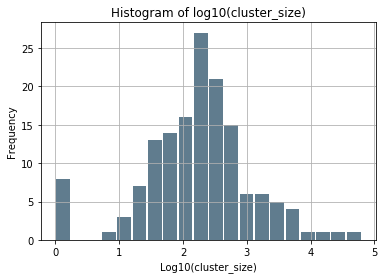

In [89]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(np.log10(df[:,1]))
commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of log10(cluster_size)')
plt.xlabel('Log10(cluster_size)')
#plt.grid(axis='y', alpha=0.75)

Text(0.5, 0, 'cluster_size')

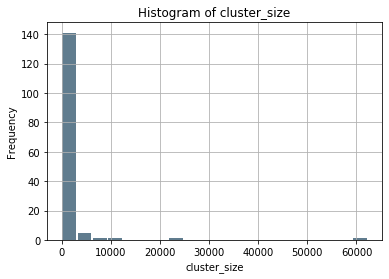

In [90]:
commutes = pd.Series(df[:,1])
commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of cluster_size')
plt.xlabel('cluster_size')

In [72]:
import pickle
filename="kmeans_1_15_wo_count_division"

pickle.dump(kmeans, open(filename, 'wb'))

#kmeans = pickle.load(open(filename, 'rb'))

In [132]:
fset=set(np.asarray(filenames)[np.where(kmeans.labels_==4)[0].tolist()])
#[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
[open(f).readlines() for f in fset]

[['#!/usr/bin/python\n',
  '# -*- coding: utf-8 -*-\n',
  ' \n',
  'import re\n',
  'import math\n',
  ' \n',
  'train_data=[\n',
  '("""What Are We Searching for on Mars?\n',
  'Martians terrified me growing up. I remember watching the 1996 movie Mars Attacks! and fearing that the Red Planet harbored hostile alien neighbors. Though I was only 6 at the time, I was convinced life on Mars meant little green men wielding vaporizer guns. There was a time, not so long ago, when such an assumption about Mars wouldn’t have seemed so far-fetched.\n',
  'Like a child watching a scary movie, people freaked out after listening to “The War of the Worlds,” the now-infamous 1938 radio drama that many listeners believed was a real report about an invading Martian army. Before humans left Earth, humanity’s sense of what—or who—might be in our galactic neighborhood was, by today’s standards, remarkably optimistic.\n',
  '""",\n',
  '"science"),\n',
  '("""Mountains of Ice are Melting, But Don\'t Panic 

In [47]:
centers_descr=[]
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))
centers_descr.append((78,["code","javascript"]))


In [220]:
model.save("model_1_15_gensim")
#model = gensim.models.Word2Vec.load("model_1_15_gensim")

2019-09-15 04:29:06,101 : INFO : loading Word2Vec object from model_1_15_gensim
2019-09-15 04:29:15,855 : INFO : loading wv recursively from model_1_15_gensim.wv.* with mmap=None
2019-09-15 04:29:15,856 : INFO : loading vectors from model_1_15_gensim.wv.vectors.npy with mmap=None
2019-09-15 04:29:16,262 : INFO : setting ignored attribute vectors_norm to None
2019-09-15 04:29:16,263 : INFO : loading vocabulary recursively from model_1_15_gensim.vocabulary.* with mmap=None
2019-09-15 04:29:16,263 : INFO : loading trainables recursively from model_1_15_gensim.trainables.* with mmap=None
2019-09-15 04:29:16,264 : INFO : loading syn1neg from model_1_15_gensim.trainables.syn1neg.npy with mmap=None
2019-09-15 04:29:16,649 : INFO : setting ignored attribute cum_table to None
2019-09-15 04:29:16,649 : INFO : loaded model_1_15_gensim


In [217]:
import pickle
filename="kmeans_1_15_wo_count_division"

pickle.dump(kmeans, open(filename, 'wb'))

#kmeans = pickle.load(open(filename, 'rb'))

179241

### Similarity between two words in the vocabulary

You can even use the Word2Vec model to return the similarity between two words that are present in the vocabulary. 

Under the hood, the above three snippets computes the cosine similarity between the two specified words using word vectors of each. From the scores, it makes sense that `dirty` is highly similar to `smelly` but `dirty` is dissimilar to `clean`. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0]. You can read more about cosine similarity scoring [here](https://en.wikipedia.org/wiki/Cosine_similarity).

### Find the odd one out
You can even use Word2Vec to find odd items given a list of items.

## Understanding some of the parameters
To train the model earlier, we had to set some parameters. Now, let's try to understand what some of them mean. For reference, this is the command that we used to train the model.

```
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
```

### `size`
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me. 

### `window`
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window. 

### `min_count`
Minimium frequency count of words. The model would ignore words that do not statisfy the `min_count`. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

### `workers`
How many threads to use behind the scenes?


## When should you use Word2Vec?

There are many application scenarios for Word2Vec. Imagine if you need to build a sentiment lexicon. Training a Word2Vec model on large amounts of user reviews helps you achieve that. You have a lexicon for not just sentiment, but for most words in the vocabulary. 

Beyond, raw unstructured text data, you could also use Word2Vec for more structured data. For example, if you had tags for a million stackoverflow questions and answers, you could find tags that are related to a given tag and recommend the related ones for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. Granted, you still need a large number of examples to make it work. 
